<div style="font-family:monospace; font-size:15px; line-height:1.5; border-top: 1px solid black; border-bottom: 1px solid black; padding: 10px; text-align: center;">
    <strong>ADAM-SINDy OPTIMIZATION - DYNAMICAL SYSTEM IDENTIFICATION</strong><br>
    <strong></strong> SIVA VIKNESH & YOUNES TATARI <br>
    <strong></strong> siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com<br>
    <strong></strong> SCIENTIFIC COMPUTING & IMAGING INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA<br>
</div>

In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


Combustion:  <br>
Paper: Symbolic regression via neural networks :
\
Chemical kinetics with Arrhenius rate dependence


$$
\dot{\alpha} = -k \alpha  e^{\theta} + \mu
$$

$$
\dot{\theta} = \alpha e^{\theta} - \theta
$$

Parameters: \\(k\\), \\(\mu\\)

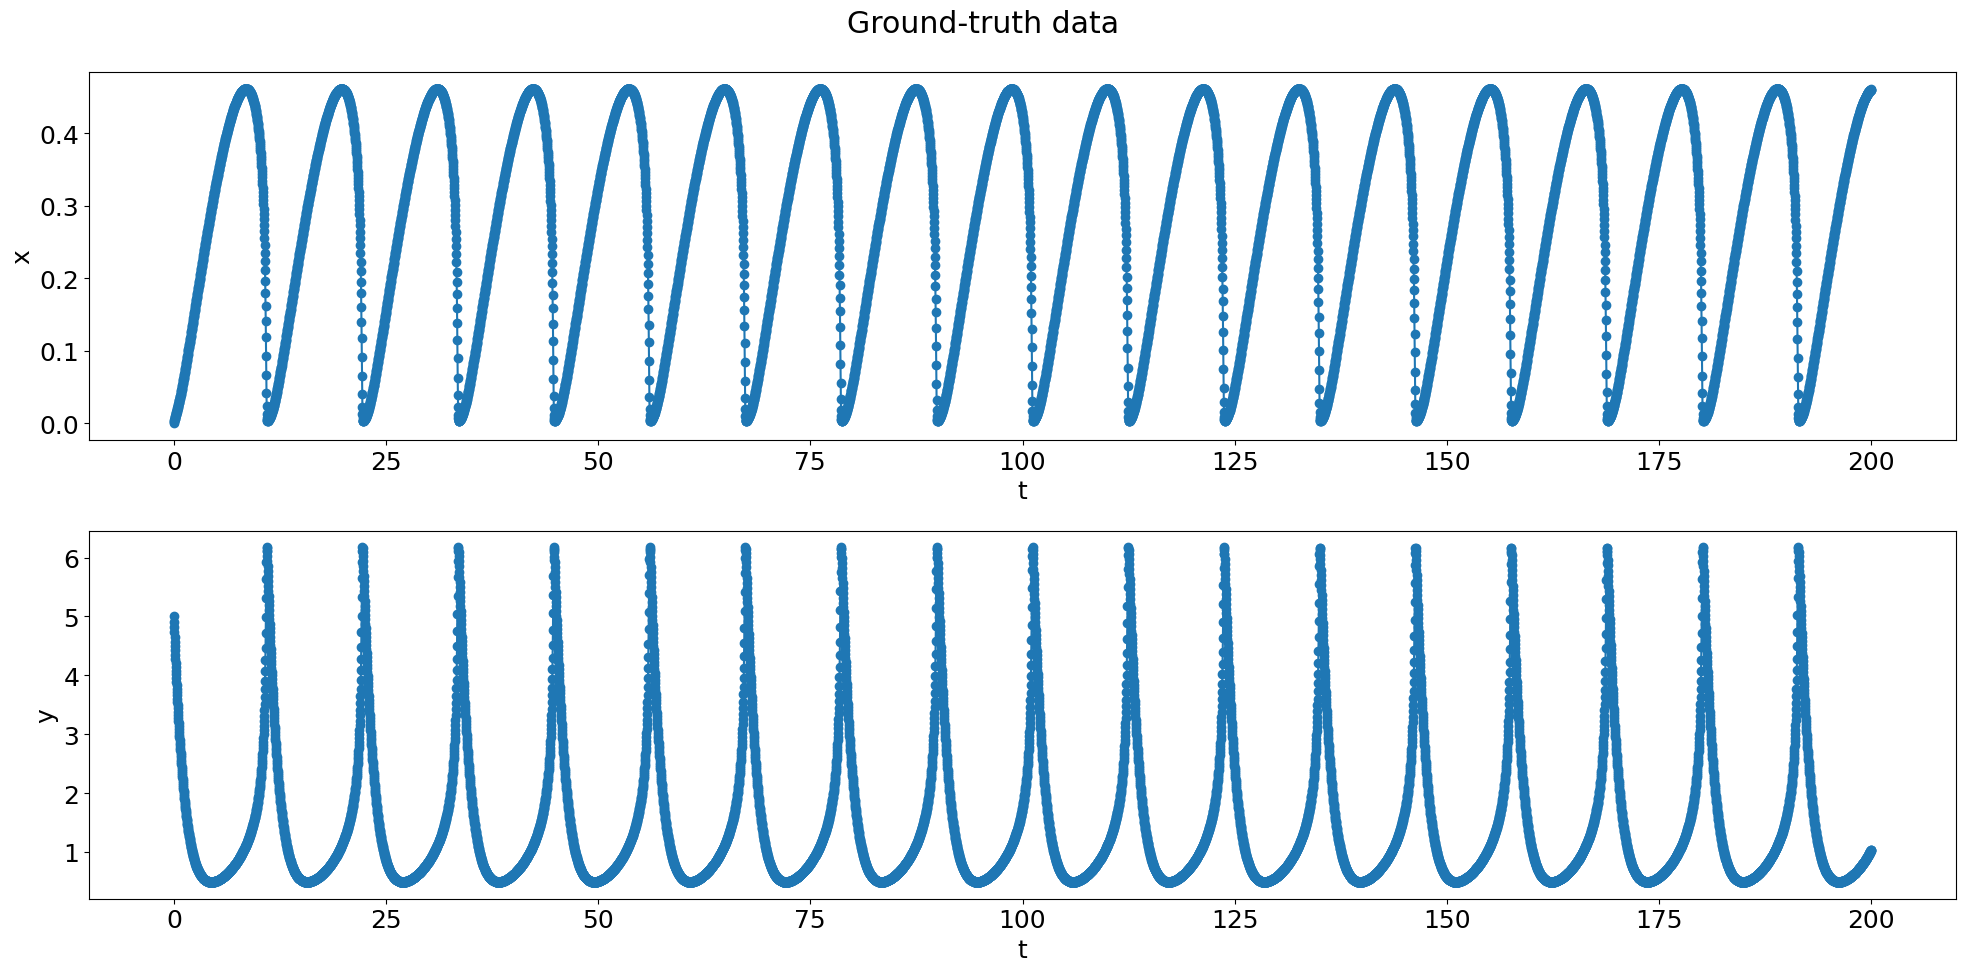

In [2]:
k  = 0.07
mu = 0.1
a  = 1.015
b  = 1.025

def oscillator_deriv(x_y, t0, a =a, b =b,  k=k, mu =mu):
    x, y = x_y
    dxdt = -k*x*np.exp(a*y) + mu
    dydt = x*np.exp(b*y) - y
    return [dxdt, dydt]

np.random.seed(123)
x0 = (0.0,5.0)

# Time points
t = np.linspace(0, 200, 10000)

x_t = integrate.odeint(oscillator_deriv, x0, t, rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))
x, y = x_t.T

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o')
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o')
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

fig.tight_layout()
plt.show()

In [3]:
# COMPUTING THE COMBINATIONS AMONG THE THREE CHOSEN TEMPORAL MODES

def POOL_DATA(yin, nVars, polyorder):
    n = yin.shape[0]
    yout = torch.zeros((n, 1)).to(processor)

    # poly order 0
    yout[:, 0] = torch.ones(n)

    # poly order 1
    for i in range(nVars):
        yout = torch.cat((yout, yin[:, i].reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i, nVars):
                yout = torch.cat((yout, (yin[:, i] * yin[:, j]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    yout = torch.cat((yout, (yin[:, i] * yin[:, j] * yin[:, k]).reshape((yin.shape[0], 1))), dim=1).to(processor)

    return yout

def DERIVATIVE(x, y, k, a, b, mu):
    dxdt = -k*torch.mul(x,torch.exp(a*y)) + mu
    dydt = torch.mul(x, torch.exp(b*y)) - y
    return torch.vstack((dxdt, dydt)).T


AVAILABLE PROCESSOR: cuda 



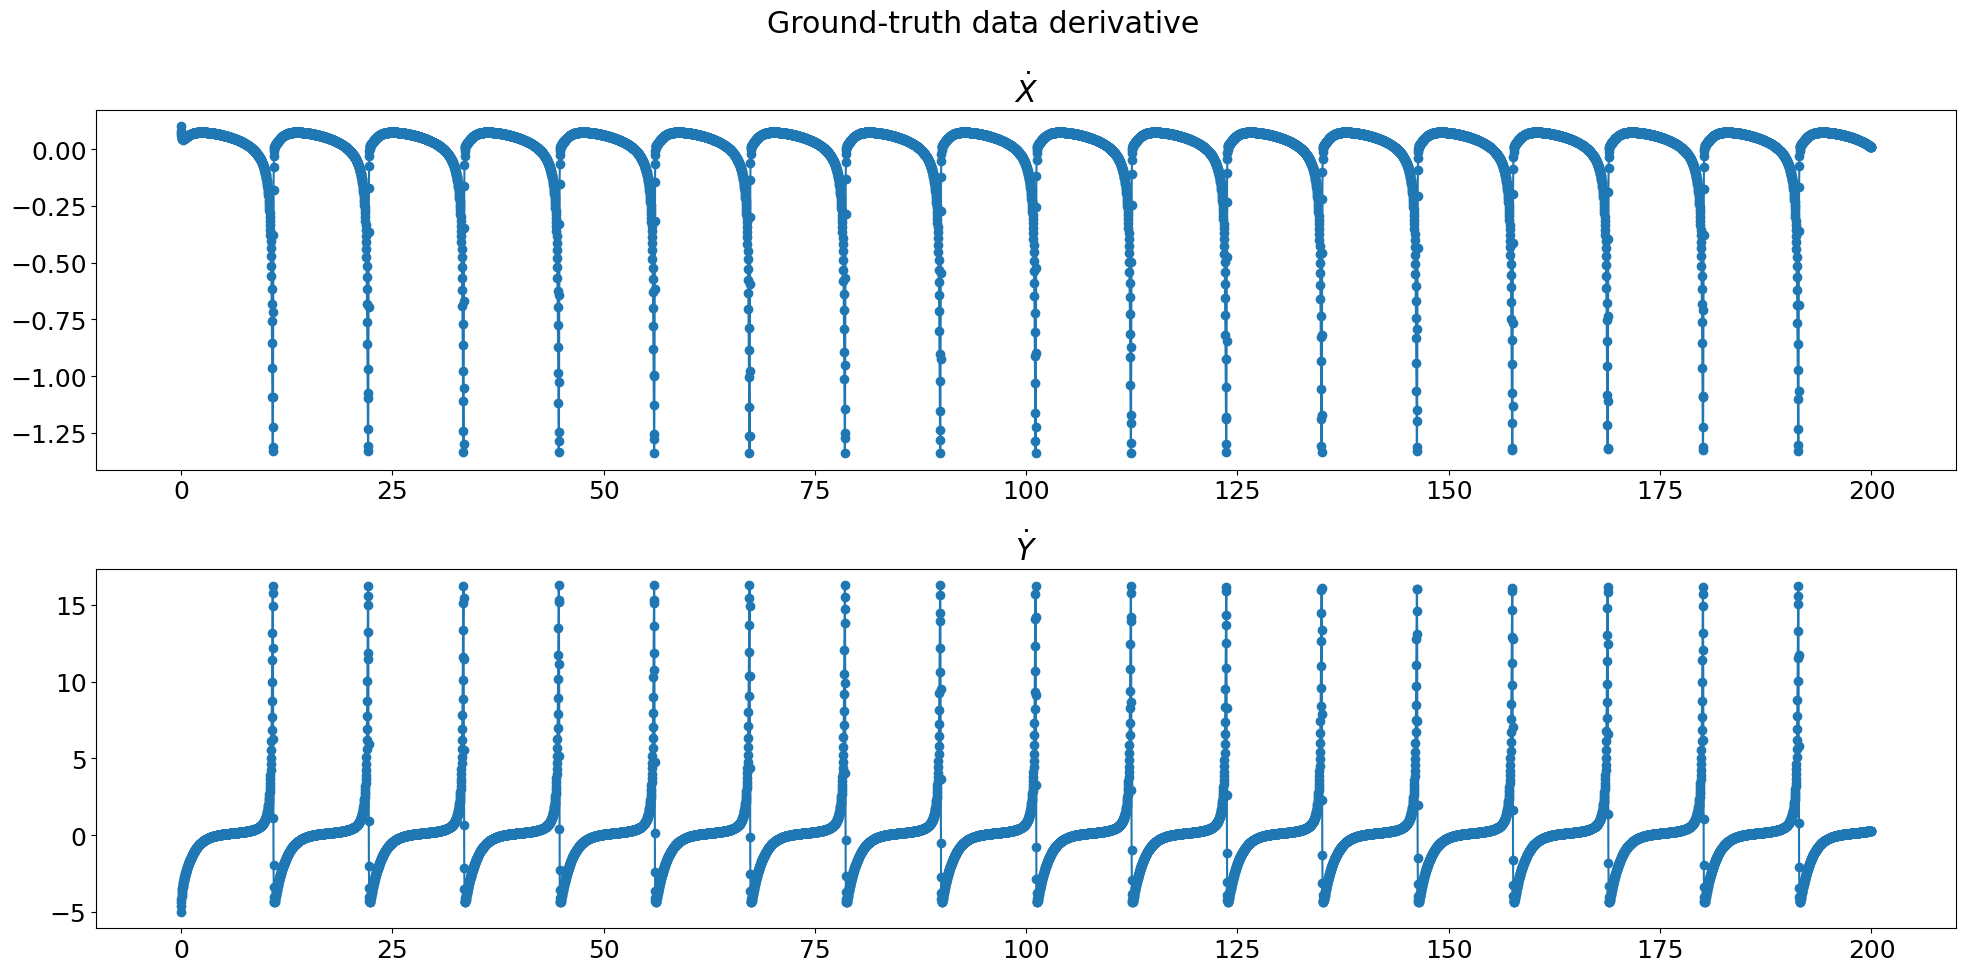

In [4]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

N_modes  = 2
x_t      = torch.Tensor(x_t).to(processor)
x        = torch.Tensor(x).to(processor)
y        = torch.Tensor(y).to(processor)
t        = torch.Tensor(t).to(processor)

A_candidates = POOL_DATA (x_t, 2, 1).to(processor)
A1A2_time_deriv = DERIVATIVE (x, y, k, a, b, mu).to(processor)

# HYPERPARAMETERS FOR THE SINDy POD METHODOLOGY
Epochs        = 40000
learning_rate = 1e-2
step_epoch    = 3000
decay_rate    = 0.50
tolerance     = 5e-3

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data derivative')

ax[0].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 0].detach().cpu().numpy(), '-o')
ax[0].set_title(r"$\dot{X}$")

ax[1].plot(t.detach().cpu().numpy(), A1A2_time_deriv[:, 1].detach().cpu().numpy(), '-o')
ax[1].set_title(r"$\dot{Y}$")

fig.tight_layout()
plt.show()


In [5]:
class SINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sin(self.b*x)
        return output

class COSINE_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.cos(self.b*x)
        return output

class POWER_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.sign(x) * torch.pow(torch.abs(x), self.b)
        return output

class EXP_TERM (nn.Module):
    def __init__(self, b):
        super().__init__()
        self.b = b

    def forward(self, x):
        output = torch.exp(self.b*x)
        return output


In [6]:
class ADAM_SINDy_MODEL(nn.Module):
    def __init__(self, a, asine, acosine, aexp, axsine, axcosine, axexp):
        super().__init__()    
        self.a        = a
        self.asine    = asine
        self.acosine  = acosine
        self.aexp     = aexp
        self.axsine   = axsine
        self.axcosine = axcosine
        self.axexp    = axexp
        
        self.sine     = SINE_TERM   (self.asine)
        self.cosine   = COSINE_TERM (self.acosine)
        self.exp      = EXP_TERM    (self.aexp)
        self.xsine    = SINE_TERM   (self.axsine)
        self.xcosine  = COSINE_TERM (self.axcosine)
        self.xexp     = EXP_TERM    (self.axexp)
        
    def forward(self, x):
        x1             = x [:, 1:]
        output_sine    = self.sine   (x1)
        output_cosine  = self.cosine (x1)
        output_exp     = self.exp    (x1)

        output_xsine   = self.xsine   (x1)
        output_xcosine = self.xcosine (x1)
        output_xexp    = self.xexp    (x1)
 
        output_xsine   = (output_xsine  [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xcosine = (output_xcosine[:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        output_xexp    = (output_xexp   [:,None] * x1[...,None]).reshape(x1.shape[0], -1)
        
        output = torch.hstack((x, output_sine, output_cosine, output_exp, output_xsine, output_xcosine, output_xexp)) @ self.a
        return output


In [7]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(21, N_modes, requires_grad= True, device= processor)

SINE_ADT    = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

XSINE_ADT   = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)
XCOSINE_ADT = torch.ones(A_candidates.shape[1]-1, N_modes, requires_grad= True, device= processor)

EXP_ADT     = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)
XEXP_ADT    = torch.full((A_candidates.shape[1]-1, N_modes), 1.0, requires_grad= True, device= processor)

In [8]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, EXP_ADT, XEXP_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
torch.manual_seed(42)
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
nn.init.normal_(WEIGHTS, mean=0, std=1.0)
Lambda   = Parameter(torch.tensor(1.0), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda],  lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)

**Adaptive SINDy training**

In [9]:
# TEMPORAL MODE 1
A1_DT = ADAM_SINDy_MODEL(COEFF_ADT [:, 0], SINE_ADT [:, 0], COSINE_ADT[:, 0], EXP_ADT[:, 0], XSINE_ADT [:, 0], XCOSINE_ADT[:, 0], XEXP_ADT [:, 0]).to(processor)

# TEMPORAL MODE 2
A2_DT = ADAM_SINDy_MODEL(COEFF_ADT [:, 1], SINE_ADT [:, 1], COSINE_ADT[:, 1], EXP_ADT[:, 1], XSINE_ADT [:, 1], XCOSINE_ADT[:, 1], XEXP_ADT [:, 1]).to(processor)

Loss_data     = torch.empty(size=(Epochs, 1))
Gamma_correct   = torch.empty(size=(Epochs, 1))
Gamma_incorrect = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    A1_out, A2_out  = A1_DT (A_candidates), A2_DT (A_candidates)
    output_data  = torch.stack((A1_out , A2_out), dim = 1)
    loss_epoch   = loss_function (A1A2_time_deriv, output_data) + torch.linalg.matrix_norm(torch.abs(WEIGHTS)*COEFF_ADT, ord =1)
    
    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    optim_weights.zero_grad()
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()
        optim_weights.step()
        Loss_data [epoch] = loss_epoch.detach()
        Gamma_incorrect [epoch] = WEIGHTS [0, 0].detach()
        Gamma_correct   [epoch] = WEIGHTS [1, 0].detach()
        
        COEFF_ADT   [torch.abs(COEFF_ADT)   <= tolerance] = 0.0
        SINE_ADT    [torch.abs(SINE_ADT)    <= tolerance] = 0.0
        COSINE_ADT  [torch.abs(COSINE_ADT)  <= tolerance] = 0.0
        XSINE_ADT   [torch.abs(XSINE_ADT)   <= tolerance] = 0.0
        XCOSINE_ADT [torch.abs(XCOSINE_ADT) <= tolerance] = 0.0
        EXP_ADT     [torch.abs(EXP_ADT)     <= tolerance] = 0.0
        XEXP_ADT    [torch.abs(XEXP_ADT)    <= tolerance] = 0.0
        
    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)
       
    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

LOSS DATA, [EPOCH = 0 ]: 186371.265625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1 ]: 162838.546875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2 ]: 142378.46875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 3 ]: 124636.796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 4 ]: 109284.171875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 5 ]: 96018.5859375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 6 ]: 84566.8671875
LEARNING RATE: 0.01
************************************************************************

LOSS DATA, [EPOCH = 67 ]: 3780.5380859375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 68 ]: 3713.842041015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 69 ]: 3649.139404296875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 70 ]: 3586.33447265625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 71 ]: 3525.31591796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 72 ]: 3465.989990234375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 73 ]: 3408.289794921875
LEARNING RATE: 0.01
****************************************

LOSS DATA, [EPOCH = 127 ]: 1582.408447265625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 128 ]: 1562.373046875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 129 ]: 1542.645263671875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 130 ]: 1523.2099609375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 131 ]: 1504.0732421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 132 ]: 1485.2208251953125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 133 ]: 1466.63623046875
LEARNING RATE: 0.01
************************************

LOSS DATA, [EPOCH = 189 ]: 768.3073120117188
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 190 ]: 760.8118286132812
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 191 ]: 753.4156494140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 192 ]: 746.1011962890625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 193 ]: 738.8698120117188
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 194 ]: 731.7157592773438
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 195 ]: 724.6484375
LEARNING RATE: 0.01
***********************************

LOSS DATA, [EPOCH = 251 ]: 433.4072265625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 252 ]: 429.6072082519531
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 253 ]: 425.84637451171875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 254 ]: 422.11578369140625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 255 ]: 418.4197082519531
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 256 ]: 414.76678466796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 257 ]: 411.1357116699219
LEARNING RATE: 0.01
*****************************

LOSS DATA, [EPOCH = 313 ]: 254.10694885253906
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 314 ]: 251.97427368164062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 315 ]: 249.85714721679688
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 316 ]: 247.77078247070312
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 317 ]: 245.69091796875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 318 ]: 243.63697814941406
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 319 ]: 241.6067352294922
LEARNING RATE: 0.01
**************************

LOSS DATA, [EPOCH = 375 ]: 151.91038513183594
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 376 ]: 150.65663146972656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 377 ]: 149.4248046875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 378 ]: 148.2313232421875
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 379 ]: 147.03579711914062
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 380 ]: 145.83201599121094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 381 ]: 144.63319396972656
LEARNING RATE: 0.01
***************************

LOSS DATA, [EPOCH = 438 ]: 91.71125793457031
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 439 ]: 90.98622131347656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 440 ]: 90.27375030517578
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 441 ]: 89.56739044189453
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 442 ]: 88.8780746459961
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 443 ]: 88.18463134765625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 444 ]: 87.50462341308594
LEARNING RATE: 0.01
******************************

LOSS DATA, [EPOCH = 500 ]: 57.34891891479492
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 501 ]: 56.95064926147461
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 502 ]: 56.53141784667969
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 503 ]: 56.119476318359375
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 504 ]: 55.709510803222656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 505 ]: 55.30441665649414
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 506 ]: 54.915409088134766
LEARNING RATE: 0.01
**************************

LOSS DATA, [EPOCH = 563 ]: 37.179481506347656
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 564 ]: 36.93399429321289
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 565 ]: 36.69923782348633
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 566 ]: 36.476593017578125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 567 ]: 36.24540710449219
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 568 ]: 36.02015686035156
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 569 ]: 35.7830810546875
LEARNING RATE: 0.01
****************************

LOSS DATA, [EPOCH = 626 ]: 25.494678497314453
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 627 ]: 25.347707748413086
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 628 ]: 25.204553604125977
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 629 ]: 25.073070526123047
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 630 ]: 24.931255340576172
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 631 ]: 24.797927856445312
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 632 ]: 24.668968200683594
LEARNING RATE: 0.01
**********************

LOSS DATA, [EPOCH = 687 ]: 18.48487091064453
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 688 ]: 18.4058780670166
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 689 ]: 18.31427001953125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 690 ]: 18.20685577392578
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 691 ]: 18.118553161621094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 692 ]: 18.021663665771484
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 693 ]: 17.930347442626953
LEARNING RATE: 0.01
***************************

LOSS DATA, [EPOCH = 750 ]: 13.188301086425781
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 751 ]: 13.115148544311523
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 752 ]: 13.047009468078613
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 753 ]: 12.968534469604492
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 754 ]: 12.897811889648438
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 755 ]: 12.816859245300293
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 756 ]: 12.738516807556152
LEARNING RATE: 0.01
**********************

LOSS DATA, [EPOCH = 813 ]: 8.793365478515625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 814 ]: 8.733514785766602
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 815 ]: 8.68934440612793
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 816 ]: 8.624449729919434
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 817 ]: 8.577677726745605
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 818 ]: 8.510751724243164
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 819 ]: 8.451526641845703
LEARNING RATE: 0.01
******************************

LOSS DATA, [EPOCH = 878 ]: 5.6259307861328125
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 879 ]: 5.585151672363281
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 880 ]: 5.551316738128662
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 881 ]: 5.522099494934082
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 882 ]: 5.48219633102417
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 883 ]: 5.442431926727295
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 884 ]: 5.41133451461792
LEARNING RATE: 0.01
******************************

LOSS DATA, [EPOCH = 943 ]: 3.7135732173919678
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 944 ]: 3.6987040042877197
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 945 ]: 3.691347122192383
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 946 ]: 3.6686458587646484
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 947 ]: 3.634533643722534
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 948 ]: 3.6087169647216797
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 949 ]: 3.5868587493896484
LEARNING RATE: 0.01
************************

LOSS DATA, [EPOCH = 1026 ]: 2.4660215377807617
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1027 ]: 2.4610586166381836
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1028 ]: 2.4615087509155273
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1029 ]: 2.461512327194214
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1030 ]: 2.452191114425659
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1031 ]: 2.436769485473633
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1032 ]: 2.4203529357910156
LEARNING RATE: 0.01
******************

LOSS DATA, [EPOCH = 1090 ]: 2.0312774181365967
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1091 ]: 2.037205457687378
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1092 ]: 2.0321545600891113
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1093 ]: 2.0313727855682373
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1094 ]: 2.023177146911621
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1095 ]: 2.0198051929473877
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1096 ]: 2.0076100826263428
LEARNING RATE: 0.01
*****************

LOSS DATA, [EPOCH = 1152 ]: 1.7594348192214966
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1153 ]: 1.7648587226867676
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1154 ]: 1.7583156824111938
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1155 ]: 1.7571858167648315
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1156 ]: 1.7708446979522705
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1157 ]: 1.7589263916015625
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1158 ]: 1.7425259351730347
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1215 ]: 1.5006729364395142
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1216 ]: 1.4868271350860596
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1217 ]: 1.4934301376342773
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1218 ]: 1.4902119636535645
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1219 ]: 1.4807137250900269
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1220 ]: 1.4840400218963623
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1221 ]: 1.4788018465042114
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1279 ]: 1.2955268621444702
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1280 ]: 1.2892773151397705
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1281 ]: 1.2707329988479614
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1282 ]: 1.2499784231185913
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1283 ]: 1.2579050064086914
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1284 ]: 1.261282205581665
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1285 ]: 1.2732715606689453
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1341 ]: 1.0780786275863647
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1342 ]: 1.0740306377410889
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1343 ]: 1.0856868028640747
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1344 ]: 1.083696722984314
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1345 ]: 1.0790879726409912
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1346 ]: 1.0719410181045532
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1347 ]: 1.0612338781356812
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1411 ]: 0.9062286615371704
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1412 ]: 0.9050425887107849
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1413 ]: 0.8863810300827026
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1414 ]: 0.888867199420929
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1415 ]: 0.8954788446426392
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1416 ]: 0.9064513444900513
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1417 ]: 0.9040430188179016
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1475 ]: 0.7629953026771545
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1476 ]: 0.7576718330383301
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1477 ]: 0.7675503492355347
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1478 ]: 0.7832913994789124
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1479 ]: 0.7768029570579529
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1480 ]: 0.7717416286468506
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1481 ]: 0.785145103931427
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1539 ]: 0.6644042134284973
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1540 ]: 0.6553518772125244
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1541 ]: 0.6866283416748047
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1542 ]: 0.6807758212089539
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1543 ]: 0.658036470413208
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1544 ]: 0.6579409837722778
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1545 ]: 0.6623899340629578
LEARNING RATE: 0.01
****************

LOSS DATA, [EPOCH = 1603 ]: 0.5721035599708557
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1604 ]: 0.5769293308258057
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1605 ]: 0.5628653168678284
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1606 ]: 0.5560041069984436
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1607 ]: 0.5534269213676453
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1608 ]: 0.5598873496055603
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1609 ]: 0.5587226152420044
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1666 ]: 0.48039573431015015
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1667 ]: 0.4680464267730713
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1668 ]: 0.4698331356048584
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1669 ]: 0.4624220132827759
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1670 ]: 0.46632519364356995
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1671 ]: 0.46182093024253845
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1672 ]: 0.4688895642757416
LEARNING RATE: 0.01
************

LOSS DATA, [EPOCH = 1735 ]: 0.3919742703437805
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1736 ]: 0.4066416621208191
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1737 ]: 0.4103100299835205
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1738 ]: 0.3905898332595825
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1739 ]: 0.39555853605270386
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1740 ]: 0.4035615026950836
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1741 ]: 0.40124255418777466
LEARNING RATE: 0.01
*************

LOSS DATA, [EPOCH = 1810 ]: 0.324126660823822
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1811 ]: 0.3457104563713074
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1812 ]: 0.3480651080608368
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1813 ]: 0.32791391015052795
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1814 ]: 0.323135107755661
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1815 ]: 0.31018733978271484
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1816 ]: 0.3034846782684326
LEARNING RATE: 0.01
***************

LOSS DATA, [EPOCH = 1874 ]: 0.26611196994781494
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1875 ]: 0.26916003227233887
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1876 ]: 0.2797374129295349
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1877 ]: 0.26238828897476196
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1878 ]: 0.25699901580810547
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1879 ]: 0.2625327408313751
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1880 ]: 0.2586161494255066
LEARNING RATE: 0.01
***********

LOSS DATA, [EPOCH = 1938 ]: 0.21591034531593323
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1939 ]: 0.21823887526988983
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1940 ]: 0.2271033525466919
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1941 ]: 0.22066301107406616
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1942 ]: 0.2124975025653839
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1943 ]: 0.19846820831298828
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 1944 ]: 0.20709392428398132
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 2001 ]: 0.17822030186653137
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2002 ]: 0.18186089396476746
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2003 ]: 0.17873495817184448
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2004 ]: 0.1596366912126541
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2005 ]: 0.14309118688106537
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2006 ]: 0.16608738899230957
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2007 ]: 0.17235839366912842
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 2065 ]: 0.1545434147119522
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2066 ]: 0.14577411115169525
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2067 ]: 0.1437070071697235
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2068 ]: 0.14279915392398834
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2069 ]: 0.1368381381034851
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2070 ]: 0.14234337210655212
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2071 ]: 0.1477791666984558
LEARNING RATE: 0.01
************

LOSS DATA, [EPOCH = 2128 ]: 0.11453530192375183
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2129 ]: 0.11892729997634888
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2130 ]: 0.10659875720739365
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2131 ]: 0.10111865401268005
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2132 ]: 0.10976649820804596
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2133 ]: 0.11389343440532684
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2134 ]: 0.10623452812433243
LEARNING RATE: 0.01
********

LOSS DATA, [EPOCH = 2192 ]: 0.08981120586395264
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2193 ]: 0.08349379152059555
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2194 ]: 0.08552828431129456
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2195 ]: 0.08127132058143616
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2196 ]: 0.08567292243242264
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2197 ]: 0.08611886203289032
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2198 ]: 0.08897840231657028
LEARNING RATE: 0.01
********

LOSS DATA, [EPOCH = 2256 ]: 0.09261798858642578
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2257 ]: 0.09194348007440567
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2258 ]: 0.07826034724712372
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2259 ]: 0.07753881812095642
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2260 ]: 0.08657823503017426
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2261 ]: 0.08887200802564621
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2262 ]: 0.0840250551700592
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 2317 ]: 0.06636478751897812
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2318 ]: 0.05987100303173065
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2319 ]: 0.05636058375239372
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2320 ]: 0.06380955129861832
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2321 ]: 0.0625789612531662
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2322 ]: 0.0653395801782608
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2323 ]: 0.06162368133664131
LEARNING RATE: 0.01
**********

LOSS DATA, [EPOCH = 2380 ]: 0.06558127701282501
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2381 ]: 0.05536121875047684
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2382 ]: 0.04848424345254898
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2383 ]: 0.0532115176320076
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2384 ]: 0.0584716871380806
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2385 ]: 0.05382174253463745
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2386 ]: 0.052560076117515564
LEARNING RATE: 0.01
*********

LOSS DATA, [EPOCH = 2446 ]: 0.06169504672288895
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2447 ]: 0.060408204793930054
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2448 ]: 0.05301579833030701
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2449 ]: 0.049810051918029785
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2450 ]: 0.05151128023862839
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2451 ]: 0.0569782555103302
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2452 ]: 0.05344868078827858
LEARNING RATE: 0.01
*******

LOSS DATA, [EPOCH = 2509 ]: 0.04499340057373047
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2510 ]: 0.04914102330803871
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2511 ]: 0.04302595555782318
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2512 ]: 0.03804668411612511
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2513 ]: 0.043039772659540176
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2514 ]: 0.04228319600224495
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2515 ]: 0.04406518489122391
LEARNING RATE: 0.01
*******

LOSS DATA, [EPOCH = 2572 ]: 0.04145101457834244
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2573 ]: 0.04540877044200897
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2574 ]: 0.051830828189849854
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2575 ]: 0.05574449896812439
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2576 ]: 0.05288179963827133
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2577 ]: 0.04502139240503311
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2578 ]: 0.03765890747308731
LEARNING RATE: 0.01
*******

LOSS DATA, [EPOCH = 2635 ]: 0.034765053540468216
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2636 ]: 0.030983947217464447
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2637 ]: 0.02630394697189331
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2638 ]: 0.025899037718772888
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2639 ]: 0.036118485033512115
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2640 ]: 0.0349041149020195
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2641 ]: 0.027122166007757187
LEARNING RATE: 0.01
****

LOSS DATA, [EPOCH = 2696 ]: 0.02171102911233902
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2697 ]: 0.02561710588634014
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2698 ]: 0.022491974756121635
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2699 ]: 0.02209281735122204
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2700 ]: 0.028437117114663124
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2701 ]: 0.033665742725133896
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2702 ]: 0.027303840965032578
LEARNING RATE: 0.01
****

LOSS DATA, [EPOCH = 2760 ]: 0.01577877625823021
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2761 ]: 0.01407560147345066
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2762 ]: 0.0184584092348814
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2763 ]: 0.02107817307114601
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2764 ]: 0.020092450082302094
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2765 ]: 0.016317244619131088
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2766 ]: 0.014560475945472717
LEARNING RATE: 0.01
******

LOSS DATA, [EPOCH = 2823 ]: 0.015180077403783798
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2824 ]: 0.015687279403209686
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2825 ]: 0.015909843146800995
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2826 ]: 0.023717280477285385
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2827 ]: 0.02833678387105465
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2828 ]: 0.02632834203541279
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2829 ]: 0.03397734463214874
LEARNING RATE: 0.01
****

LOSS DATA, [EPOCH = 2887 ]: 0.01632474921643734
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2888 ]: 0.013259363360702991
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2889 ]: 0.017213698476552963
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2890 ]: 0.01573305018246174
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2891 ]: 0.015011864714324474
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2892 ]: 0.015535091981291771
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2893 ]: 0.017090164124965668
LEARNING RATE: 0.01
***

LOSS DATA, [EPOCH = 2968 ]: 0.02011323906481266
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2969 ]: 0.015655480325222015
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2970 ]: 0.009880168363451958
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2971 ]: 0.01815631240606308
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2972 ]: 0.021356888115406036
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2973 ]: 0.015670862048864365
LEARNING RATE: 0.01
*************************************************************************************
LOSS DATA, [EPOCH = 2974 ]: 0.016464345157146454
LEARNING RATE: 0.01
***

LOSS DATA, [EPOCH = 3032 ]: 0.01089406292885542
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3033 ]: 0.008129515685141087
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3034 ]: 0.008398760110139847
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3035 ]: 0.009677954949438572
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3036 ]: 0.009732411243021488
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3037 ]: 0.007087497506290674
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3038 ]: 0.007758431136608124
LEARNING RATE: 0

LOSS DATA, [EPOCH = 3095 ]: 0.01000588946044445
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3096 ]: 0.00914933905005455
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3097 ]: 0.006823371164500713
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3098 ]: 0.009194847196340561
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3099 ]: 0.0114364642649889
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3100 ]: 0.010638097301125526
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3101 ]: 0.008769357576966286
LEARNING RATE: 0.00

LOSS DATA, [EPOCH = 3158 ]: 0.006377863232046366
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3159 ]: 0.008364683017134666
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3160 ]: 0.00797341763973236
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3161 ]: 0.00600818358361721
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3162 ]: 0.006591738201677799
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3163 ]: 0.007797323167324066
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3164 ]: 0.006428159773349762
LEARNING RATE: 0.

LOSS DATA, [EPOCH = 3220 ]: 0.006453203037381172
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3221 ]: 0.007150378543883562
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3222 ]: 0.0067350780591368675
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3223 ]: 0.005215565674006939
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3224 ]: 0.005380671471357346
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3225 ]: 0.005471869837492704
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3226 ]: 0.0053008683025836945
LEARNING RATE

LOSS DATA, [EPOCH = 3284 ]: 0.008142760023474693
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3285 ]: 0.008103689178824425
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3286 ]: 0.006275325547903776
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3287 ]: 0.006657586432993412
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3288 ]: 0.005294085014611483
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3289 ]: 0.005486322566866875
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3290 ]: 0.006205894984304905
LEARNING RATE: 

LOSS DATA, [EPOCH = 3347 ]: 0.004432084504514933
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3348 ]: 0.004252972546964884
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3349 ]: 0.005360846873372793
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3350 ]: 0.005452094133943319
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3351 ]: 0.004461656324565411
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3352 ]: 0.0036246348172426224
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3353 ]: 0.00635149609297514
LEARNING RATE: 

LOSS DATA, [EPOCH = 3409 ]: 0.0049565802328288555
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3410 ]: 0.006646491587162018
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3411 ]: 0.005498968996107578
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3412 ]: 0.003607871476560831
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3413 ]: 0.004711281508207321
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3414 ]: 0.0034137358888983727
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3415 ]: 0.0043311757035553455
LEARNING RAT

LOSS DATA, [EPOCH = 3472 ]: 0.0024853162467479706
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3473 ]: 0.0024063116870820522
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3474 ]: 0.0030193571001291275
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3475 ]: 0.00404532253742218
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3476 ]: 0.004112351685762405
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3477 ]: 0.0024708909913897514
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3478 ]: 0.005094136577099562
LEARNING RAT

LOSS DATA, [EPOCH = 3535 ]: 0.0035038613714277744
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3536 ]: 0.003489457070827484
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3537 ]: 0.0042161899618804455
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3538 ]: 0.00441442197188735
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3539 ]: 0.0032160133123397827
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3540 ]: 0.005071918945759535
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3541 ]: 0.006535387132316828
LEARNING RATE

LOSS DATA, [EPOCH = 3609 ]: 0.004246493801474571
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3610 ]: 0.003848619759082794
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3611 ]: 0.0024527215864509344
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3612 ]: 0.0027033579535782337
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3613 ]: 0.003937373403459787
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3614 ]: 0.004118346609175205
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3615 ]: 0.003512927098199725
LEARNING RATE

LOSS DATA, [EPOCH = 3672 ]: 0.0019599618390202522
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3673 ]: 0.0013259798288345337
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3674 ]: 0.002018869621679187
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3675 ]: 0.002157029928639531
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3676 ]: 0.0015987952938303351
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3677 ]: 0.0027139675803482533
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3678 ]: 0.003133958438411355
LEARNING RA

LOSS DATA, [EPOCH = 3736 ]: 0.0024228873662650585
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3737 ]: 0.001956238178536296
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3738 ]: 0.003026707097887993
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3739 ]: 0.002840781817212701
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3740 ]: 0.0036419793032109737
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3741 ]: 0.003562381723895669
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3742 ]: 0.0026349166873842478
LEARNING RAT

LOSS DATA, [EPOCH = 3800 ]: 0.001955447718501091
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3801 ]: 0.0021463537123054266
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3802 ]: 0.001938247005455196
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3803 ]: 0.0017393087036907673
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3804 ]: 0.002281324937939644
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3805 ]: 0.002397445961833
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3806 ]: 0.0034036205615848303
LEARNING RATE: 

LOSS DATA, [EPOCH = 3863 ]: 0.0010909757111221552
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3864 ]: 0.0024028068874031305
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3865 ]: 0.003709981916472316
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3866 ]: 0.0037387909833341837
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3867 ]: 0.0024513008538633585
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3868 ]: 0.0007777081918902695
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3869 ]: 0.0017652965616434813
LEARNING 

LOSS DATA, [EPOCH = 3946 ]: 0.0018758424557745457
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3947 ]: 0.0018471481744199991
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3948 ]: 0.0010143449762836099
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3949 ]: 0.0009713171748444438
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3950 ]: 0.0017589275958016515
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3951 ]: 0.002013253280892968
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 3952 ]: 0.0017055105417966843
LEARNING 

LOSS DATA, [EPOCH = 4010 ]: 0.0020610394421964884
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4011 ]: 0.001343930489383638
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4012 ]: 0.0007065480458550155
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4013 ]: 0.0009264260879717767
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4014 ]: 0.0007741064764559269
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4015 ]: 0.0008002205286175013
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4016 ]: 0.000674339709803462
LEARNING R

LOSS DATA, [EPOCH = 4074 ]: 0.0012549175880849361
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4075 ]: 0.002456256654113531
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4076 ]: 0.003908536862581968
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4077 ]: 0.004773315042257309
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4078 ]: 0.004899307154119015
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4079 ]: 0.004616044461727142
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4080 ]: 0.006090155802667141
LEARNING RATE:

LOSS DATA, [EPOCH = 4136 ]: 0.0012889379868283868
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4137 ]: 0.0011202204041182995
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4138 ]: 0.0019461658084765077
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4139 ]: 0.0017383279046043754
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4140 ]: 0.0016137774800881743
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4141 ]: 0.0009337672381661832
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4142 ]: 0.0013131386367604136
LEARNING

LOSS DATA, [EPOCH = 4196 ]: 0.002317358274012804
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4197 ]: 0.001690989127382636
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4198 ]: 0.0022040922194719315
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4199 ]: 0.001685107359662652
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4200 ]: 0.001674432191066444
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4201 ]: 0.001797233009710908
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4202 ]: 0.0018620735500007868
LEARNING RATE

LOSS DATA, [EPOCH = 4260 ]: 0.002403661608695984
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4261 ]: 0.002843207214027643
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4262 ]: 0.002512684790417552
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4263 ]: 0.001242700032889843
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4264 ]: 0.0012670883443206549
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4265 ]: 0.0012448051711544394
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4266 ]: 0.0010207381565123796
LEARNING RAT

LOSS DATA, [EPOCH = 4324 ]: 0.0013426656369119883
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4325 ]: 0.0015637197066098452
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4326 ]: 0.0012225557584315538
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4327 ]: 0.00122741237282753
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4328 ]: 0.0013628177111968398
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4329 ]: 0.0008240062743425369
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4330 ]: 0.0014404874527826905
LEARNING R

LOSS DATA, [EPOCH = 4388 ]: 0.0005091472994536161
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4389 ]: 0.001482799998484552
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4390 ]: 0.0012850193306803703
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4391 ]: 0.0016540344804525375
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4392 ]: 0.0019436170114204288
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4393 ]: 0.001845568884164095
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4394 ]: 0.0019138739444315434
LEARNING R

LOSS DATA, [EPOCH = 4452 ]: 0.002725479891523719
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4453 ]: 0.002735865768045187
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4454 ]: 0.0020897856447845697
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4455 ]: 0.0019112953450530767
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4456 ]: 0.0009021418518386781
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4457 ]: 0.0010643715504556894
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4458 ]: 0.0009863615268841386
LEARNING R

LOSS DATA, [EPOCH = 4515 ]: 0.0016176061471924186
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4516 ]: 0.0024628303945064545
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4517 ]: 0.002022705040872097
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4518 ]: 0.001498008263297379
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4519 ]: 0.0014263594057410955
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4520 ]: 0.0014931745827198029
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4521 ]: 0.0010983729735016823
LEARNING R

LOSS DATA, [EPOCH = 4605 ]: 0.0015214381273835897
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4606 ]: 0.0011183354072272778
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4607 ]: 0.0006336946389637887
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4608 ]: 0.0020380280911922455
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4609 ]: 0.002102829981595278
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4610 ]: 0.0009416514076292515
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4611 ]: 0.0015876104589551687
LEARNING 

LOSS DATA, [EPOCH = 4681 ]: 0.001462338026612997
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4682 ]: 0.0010744056198745966
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4683 ]: 0.0005591934313997626
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4684 ]: 0.0007500916253775358
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4685 ]: 0.0004857066960539669
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4686 ]: 0.0013023416977375746
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4687 ]: 0.0009357527014799416
LEARNING 

LOSS DATA, [EPOCH = 4745 ]: 0.0010309249628335238
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4746 ]: 0.0007245694287121296
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4747 ]: 0.0008993333904072642
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4748 ]: 0.001037189387716353
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4749 ]: 0.0003169712726958096
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4750 ]: 0.0010492607252672315
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4751 ]: 0.0007191742188297212
LEARNING 

LOSS DATA, [EPOCH = 4807 ]: 0.0006817061803303659
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4808 ]: 0.0007698095869272947
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4809 ]: 0.0009179685730487108
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4810 ]: 0.0009141573682427406
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4811 ]: 0.001010109088383615
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4812 ]: 0.0007766869966872036
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4813 ]: 0.0005223623593337834
LEARNING 

LOSS DATA, [EPOCH = 4868 ]: 0.0006774585926905274
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4869 ]: 0.000777169712819159
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4870 ]: 0.0009260965744033456
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4871 ]: 0.00047624073340557516
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4872 ]: 0.0010036892490461469
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4873 ]: 0.0006769049214199185
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4874 ]: 0.0007705828174948692
LEARNING

LOSS DATA, [EPOCH = 4932 ]: 0.0009876210242509842
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4933 ]: 0.000665953557472676
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4934 ]: 0.0007651965133845806
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4935 ]: 0.0009192346478812397
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4936 ]: 0.0007062286604195833
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4937 ]: 0.001009712927043438
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4938 ]: 0.000684883794747293
LEARNING RA

LOSS DATA, [EPOCH = 4995 ]: 0.0009102370240725577
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4996 ]: 0.0006596158491447568
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4997 ]: 0.0009742099209688604
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4998 ]: 0.0006548792589455843
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 4999 ]: 0.0007647144375368953
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5000 ]: 0.0009134162100963295
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5001 ]: 0.00045755418250337243
LEARNIN

LOSS DATA, [EPOCH = 5059 ]: 0.0007685207528993487
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5060 ]: 0.0009161271154880524
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5061 ]: 0.00048079024418257177
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5062 ]: 0.0009681130177341402
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5063 ]: 0.0006470684893429279
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5064 ]: 0.0007659300463274121
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5065 ]: 0.0009127883822657168
LEARNIN

LOSS DATA, [EPOCH = 5119 ]: 0.0004531208542175591
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5120 ]: 0.0005242331535555422
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5121 ]: 0.0005456195794977248
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5122 ]: 0.0005181803717277944
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5123 ]: 0.000737015507183969
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5124 ]: 0.00046872085658833385
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5125 ]: 0.00013290885544847697
LEARNIN

LOSS DATA, [EPOCH = 5181 ]: 0.0013058154145255685
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5182 ]: 0.0004062744847033173
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5183 ]: 0.0011142888106405735
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5184 ]: 0.0011071785120293498
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5185 ]: 0.000332640134729445
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5186 ]: 0.0013823241461068392
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5187 ]: 0.0014651063829660416
LEARNING 

LOSS DATA, [EPOCH = 5245 ]: 0.0018141008913516998
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5246 ]: 0.001842738944105804
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5247 ]: 0.0009972042171284556
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5248 ]: 0.0002610860101412982
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5249 ]: 0.0012499000877141953
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5250 ]: 0.0017453702166676521
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5251 ]: 0.0013542355736717582
LEARNING 

LOSS DATA, [EPOCH = 5309 ]: 0.001894491957500577
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5310 ]: 0.0014912759652361274
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5311 ]: 0.0022662710398435593
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5312 ]: 0.0018772202311083674
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5313 ]: 0.001865035155788064
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5314 ]: 0.0016379710286855698
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5315 ]: 0.0013691973872482777
LEARNING R

LOSS DATA, [EPOCH = 5371 ]: 0.00031601355294696987
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5372 ]: 0.0007708879420533776
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5373 ]: 0.00045070418855175376
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5374 ]: 0.0011431023012846708
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5375 ]: 0.0012785207945853472
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5376 ]: 0.0005759112536907196
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5377 ]: 0.0008800217183306813
LEARNI

LOSS DATA, [EPOCH = 5433 ]: 0.00043878649012185633
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5434 ]: 0.0011879331432282925
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5435 ]: 0.001331207575276494
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5436 ]: 0.0005714063881896436
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5437 ]: 0.0008841088274493814
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5438 ]: 0.0005410339799709618
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5439 ]: 0.0010835760040208697
LEARNING

LOSS DATA, [EPOCH = 5499 ]: 0.00029947093571536243
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5500 ]: 0.0002954538504127413
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5501 ]: 0.0003376408712938428
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5502 ]: 0.0007507272530347109
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5503 ]: 0.0004262669535819441
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5504 ]: 0.0011673406697809696
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5505 ]: 0.0013048875844106078
LEARNIN

LOSS DATA, [EPOCH = 5563 ]: 0.0005389500292949378
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5564 ]: 0.0006262116366997361
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5565 ]: 0.0005889125750400126
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5566 ]: 0.00040156213799491525
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5567 ]: 0.0006152600981295109
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5568 ]: 0.0005674317944794893
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5569 ]: 0.0015165871009230614
LEARNIN

LOSS DATA, [EPOCH = 5627 ]: 0.0006440661381930113
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5628 ]: 0.0009387490572407842
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5629 ]: 0.0010979814687743783
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5630 ]: 0.00045462234993465245
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5631 ]: 0.000987373641692102
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5632 ]: 0.0006431386573240161
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5633 ]: 0.0009395582019351423
LEARNING

LOSS DATA, [EPOCH = 5691 ]: 0.001127095427364111
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5692 ]: 0.0008753667352721095
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5693 ]: 0.0009410541388206184
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5694 ]: 0.0007662620046176016
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5695 ]: 0.0005501253181137145
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5696 ]: 0.00019999190408270806
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5697 ]: 0.00038339424645528197
LEARNIN

LOSS DATA, [EPOCH = 5754 ]: 0.0009878426790237427
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5755 ]: 0.0008936895173974335
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5756 ]: 0.0007462489884346724
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5757 ]: 0.0006804405711591244
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5758 ]: 0.0005549552151933312
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5759 ]: 0.0014156544348224998
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5760 ]: 0.0010130753507837653
LEARNING

LOSS DATA, [EPOCH = 5818 ]: 0.0002348953566979617
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5819 ]: 0.0003686753334477544
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5820 ]: 0.0005157372215762734
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5821 ]: 0.0006356160156428814
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5822 ]: 0.0014600708382204175
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5823 ]: 0.0010652921628206968
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5824 ]: 0.0006571366684511304
LEARNING

LOSS DATA, [EPOCH = 5882 ]: 0.0008930169860832393
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5883 ]: 0.0010549963917583227
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5884 ]: 0.0005846517742611468
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5885 ]: 0.0009773265337571502
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5886 ]: 0.0006327389855869114
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5887 ]: 0.0009126163204200566
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5888 ]: 0.001072238082997501
LEARNING 

LOSS DATA, [EPOCH = 5946 ]: 0.0005701232585124671
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5947 ]: 0.0009172824211418629
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5948 ]: 0.0010691412026062608
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5949 ]: 0.00038133232737891376
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5950 ]: 0.0008995599346235394
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5951 ]: 0.000569268362596631
LEARNING RATE: 0.005
*************************************************************************************
LOSS DATA, [EPOCH = 5952 ]: 0.000916552497074008
LEARNING 

LOSS DATA, [EPOCH = 6009 ]: 0.00040362332947552204
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6010 ]: 0.0008675578283146024
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6011 ]: 0.0014226393541321158
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6012 ]: 0.0013572482857853174
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6013 ]: 0.0007342307362705469
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6014 ]: 0.0004123691178392619
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6015 ]: 0.0008590100333094597
L

LOSS DATA, [EPOCH = 6070 ]: 0.00037070937105454504
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6071 ]: 0.00043741450645029545
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6072 ]: 0.0004685857566073537
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6073 ]: 0.00027613103156909347
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6074 ]: 0.000550623401068151
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6075 ]: 0.0004221660492476076
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6076 ]: 0.0002667394874151796


LOSS DATA, [EPOCH = 6134 ]: 0.0007877592579461634
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6135 ]: 0.000784736592322588
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6136 ]: 0.00021965816267766058
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6137 ]: 0.0008624860201962292
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6138 ]: 0.0012627384858205914
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6139 ]: 0.0010623725829645991
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6140 ]: 0.00042549532372504473
L

LOSS DATA, [EPOCH = 6198 ]: 0.0011604710016399622
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6199 ]: 0.0009679474169388413
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6200 ]: 0.0003139544860459864
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6201 ]: 0.0004394833231344819
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6202 ]: 0.0004697702534031123
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6203 ]: 0.00023143115686252713
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6204 ]: 0.0005586713086813688
L

LOSS DATA, [EPOCH = 6262 ]: 0.0005445941351354122
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6263 ]: 0.00017751651466824114
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6264 ]: 0.0007856471929699183
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6265 ]: 0.0007825819775462151
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6266 ]: 0.0002113477239618078
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6267 ]: 0.0008728737593628466
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6268 ]: 0.0012772789923474193
L

LOSS DATA, [EPOCH = 6326 ]: 0.0002924252185039222
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6327 ]: 0.0003339725371915847
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6328 ]: 0.00032077249488793314
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6329 ]: 0.0002671214169822633
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6330 ]: 0.0007441845955327153
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6331 ]: 0.0005891054752282798
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6332 ]: 0.00015701701340731233


LOSS DATA, [EPOCH = 6390 ]: 0.000267532974248752
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6391 ]: 0.0004269538912922144
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6392 ]: 0.00046028217184357345
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6393 ]: 9.233132004737854e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6394 ]: 5.841377060278319e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6395 ]: 7.438702596118674e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6396 ]: 0.0004420874756760895
LE

LOSS DATA, [EPOCH = 6454 ]: 0.0012451248476281762
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6455 ]: 0.0010465704835951328
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6456 ]: 0.00043027292122133076
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6457 ]: 0.00039103507879190147
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6458 ]: 0.000954345625359565
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6459 ]: 0.0009344397112727165
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6460 ]: 0.0003578426840249449
L

LOSS DATA, [EPOCH = 6518 ]: 0.00107142748311162
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6519 ]: 0.0015881777508184314
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6520 ]: 0.0015033966628834605
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6521 ]: 0.0008789944113232195
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6522 ]: 0.00023812561994418502
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6523 ]: 0.0006891184020787477
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6524 ]: 0.0005466009606607258
LEA

LOSS DATA, [EPOCH = 6582 ]: 0.0005526755703613162
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6583 ]: 0.00023501600662712008
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6584 ]: 0.0007506938418373466
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6585 ]: 0.0007502266089431942
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6586 ]: 0.00019432824046816677
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6587 ]: 0.0008610445656813681
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6588 ]: 0.0012546199141070247


LOSS DATA, [EPOCH = 6645 ]: 0.0006378840189427137
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6646 ]: 0.0005003190599381924
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6647 ]: 0.00019861236796714365
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6648 ]: 0.0007710696663707495
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6649 ]: 0.0007677352405153215
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6650 ]: 0.00021960346202831715
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6651 ]: 0.0008180083241313696


LOSS DATA, [EPOCH = 6709 ]: 0.0011310344561934471
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6710 ]: 0.0010914603481069207
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6711 ]: 0.0005095914239063859
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6712 ]: 0.0005607823841273785
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6713 ]: 0.0009758583037182689
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6714 ]: 0.0008050405886024237
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6715 ]: 0.0001326165220234543
LE

LOSS DATA, [EPOCH = 6773 ]: 0.00013845540524926037
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6774 ]: 0.00011586237815208733
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6775 ]: 3.007706800417509e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6776 ]: 0.0004476090834941715
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6777 ]: 0.0003285707498434931
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6778 ]: 0.0003256309137213975
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6779 ]: 0.00036719554918818176

LOSS DATA, [EPOCH = 6836 ]: 0.0002617974823806435
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6837 ]: 0.000621796294581145
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6838 ]: 0.00048566077020950615
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6839 ]: 0.00018343472038395703
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6840 ]: 0.00023913577024359256
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6841 ]: 0.00025535840541124344
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6842 ]: 0.0001561221288284286

LOSS DATA, [EPOCH = 6900 ]: 0.0004865248629357666
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6901 ]: 0.0004477159527596086
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6902 ]: 0.0009564353968016803
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6903 ]: 0.0009366187732666731
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6904 ]: 0.0003675156331155449
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6905 ]: 0.000701693759765476
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6906 ]: 0.0011076965602114797
LEA

LOSS DATA, [EPOCH = 6961 ]: 0.00015179361798800528
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6962 ]: 0.0005329710547812283
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6963 ]: 0.0005544934538193047
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6964 ]: 0.00011988278856733814
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6965 ]: 0.00045526691246777773
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6966 ]: 0.0003352827625349164
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 6967 ]: 0.0003262821119278669

LOSS DATA, [EPOCH = 7031 ]: 0.0007900424534454942
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7032 ]: 0.00023644775501452386
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7033 ]: 0.000811002857517451
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7034 ]: 0.0012034995015710592
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7035 ]: 0.00100864062551409
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7036 ]: 0.000505726900883019
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7037 ]: 0.00046414294047281146
LEAR

LOSS DATA, [EPOCH = 7095 ]: 0.0006012798403389752
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7096 ]: 0.00046595517778769135
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7097 ]: 0.00022437355073634535
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7098 ]: 0.0008119489648379385
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7099 ]: 0.000806474476121366
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7100 ]: 0.0002509673940949142
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7101 ]: 0.0008002579561434686
L

LOSS DATA, [EPOCH = 7158 ]: 0.0004489835409913212
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7159 ]: 0.00032939459197223186
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7160 ]: 0.0003282122779637575
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7161 ]: 0.0003699796216096729
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7162 ]: 0.0003338292008265853
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7163 ]: 0.0006020794389769435
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7164 ]: 0.0004664777952712029
L

LOSS DATA, [EPOCH = 7221 ]: 0.00019421326578594744
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7222 ]: 0.000246898562181741
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7223 ]: 0.00025076806196011603
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7224 ]: 0.00015307452122215182
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7225 ]: 0.0004863915091846138
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7226 ]: 0.0005110316560603678
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7227 ]: 0.0001027660327963531


LOSS DATA, [EPOCH = 7283 ]: 0.00038785874494351447
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7284 ]: 0.00027836437220685184
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7285 ]: 0.00032554916106164455
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7286 ]: 0.00038943608524277806
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7287 ]: 0.0006399891572073102
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7288 ]: 0.0005019985255785286
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7289 ]: 0.000321892526699230

LOSS DATA, [EPOCH = 7345 ]: 0.000907229317817837
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7346 ]: 0.00019388808868825436
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7347 ]: 0.0009972717380151153
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7348 ]: 0.0015191658167168498
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7349 ]: 0.001442628912627697
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7350 ]: 0.0008282162016257644
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7351 ]: 0.00045165338087826967
LE

LOSS DATA, [EPOCH = 7407 ]: 0.000612345349509269
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7408 ]: 0.00047508455463685095
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7409 ]: 0.00019399833399802446
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7410 ]: 0.00024933117674663663
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7411 ]: 0.0002455894718877971
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7412 ]: 0.00014659982116427273
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7413 ]: 0.0004868391843046993

LOSS DATA, [EPOCH = 7470 ]: 0.0005135075771249831
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7471 ]: 0.00010357099381508306
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7472 ]: 0.000471360981464386
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7473 ]: 0.0003492732357699424
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7474 ]: 0.000303193781292066
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7475 ]: 0.0003479907172732055
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7476 ]: 0.0003172139695379883
LEA

LOSS DATA, [EPOCH = 7533 ]: 0.0003252298047300428
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7534 ]: 0.0007955057080835104
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7535 ]: 0.0007916568429209292
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7536 ]: 0.00023783133656252176
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7537 ]: 0.0008110239286907017
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7538 ]: 0.0012027089251205325
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7539 ]: 0.0010072613367810845
L

LOSS DATA, [EPOCH = 7597 ]: 0.0003449897048994899
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7598 ]: 0.00031009860686026514
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7599 ]: 0.0003547816595528275
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7600 ]: 0.000293833581963554
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7601 ]: 0.0006048791110515594
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7602 ]: 0.00046793880756013095
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7603 ]: 0.0002012259792536497
L

LOSS DATA, [EPOCH = 7660 ]: 0.0002599728759378195
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7661 ]: 0.0002396225609118119
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7662 ]: 0.00014102146087680012
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7663 ]: 0.0004977796343155205
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7664 ]: 0.0005218277801759541
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7665 ]: 7.635947258677334e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7666 ]: 0.0004650497867260128
L

LOSS DATA, [EPOCH = 7722 ]: 0.0012225795071572065
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7723 ]: 0.0010222638957202435
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7724 ]: 0.0002932148054242134
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7725 ]: 0.0009148271637968719
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7726 ]: 0.001449689269065857
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7727 ]: 0.001380902249366045
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7728 ]: 0.0007703087176196277
LEAR

LOSS DATA, [EPOCH = 7786 ]: 0.0004649906186386943
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7787 ]: 0.00020739884348586202
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7788 ]: 0.00026287295622751117
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7789 ]: 0.0002344154054298997
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7790 ]: 0.00013474495790433139
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7791 ]: 0.0004997590440325439
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7792 ]: 0.0005266016232781112

LOSS DATA, [EPOCH = 7849 ]: 7.313010428333655e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7850 ]: 0.0004609553434420377
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7851 ]: 0.0003379091212991625
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7852 ]: 0.0003153689904138446
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7853 ]: 0.00036062818253412843
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7854 ]: 0.00034699871321208775
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7855 ]: 0.0005965085001662374


LOSS DATA, [EPOCH = 7912 ]: 0.0007791513344272971
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7913 ]: 0.0005120310233905911
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7914 ]: 0.0013149578589946032
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7915 ]: 0.001657964545302093
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7916 ]: 0.0014150728238746524
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7917 ]: 0.0006468502688221633
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7918 ]: 0.0005955068627372384
LEA

LOSS DATA, [EPOCH = 7974 ]: 0.00013052416034042835
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7975 ]: 0.0005041701369918883
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7976 ]: 0.0005309446714818478
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7977 ]: 9.41374382819049e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7978 ]: 0.0004602556873578578
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7979 ]: 0.0003372766077518463
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 7980 ]: 0.00031871264218352735
L

LOSS DATA, [EPOCH = 8037 ]: 0.00036436691880226135
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8038 ]: 0.00035460558137856424
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8039 ]: 0.0005924107390455902
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8040 ]: 0.000456745270639658
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8041 ]: 0.00022639041708316654
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8042 ]: 0.000813984137494117
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8043 ]: 0.0008093477226793766
L

LOSS DATA, [EPOCH = 8100 ]: 0.0003562190104275942
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8101 ]: 0.0006645728717558086
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8102 ]: 0.0005203676992096007
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8103 ]: 0.00030009206966497004
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8104 ]: 0.0007856734446249902
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8105 ]: 0.0007856788579374552
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8106 ]: 0.00022972859733272344


LOSS DATA, [EPOCH = 8162 ]: 0.00012437149416655302
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8163 ]: 0.0005131787620484829
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8164 ]: 0.0005399819347076118
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8165 ]: 0.00011071530025219545
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8166 ]: 0.0004582559922710061
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8167 ]: 0.00033578701550140977
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8168 ]: 0.0003293610934633761

LOSS DATA, [EPOCH = 8227 ]: 0.0005892661865800619
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8228 ]: 0.00045313482405617833
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8229 ]: 0.00021642204956151545
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8230 ]: 0.00027233839500695467
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8231 ]: 0.00022303238802123815
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8232 ]: 0.00012371447519399226
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8233 ]: 0.00051045691361650

LOSS DATA, [EPOCH = 8291 ]: 0.0008171216468326747
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8292 ]: 0.0012094619451090693
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8293 ]: 0.001010119915008545
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8294 ]: 0.00029056178755126894
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8295 ]: 0.0003830484056379646
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8296 ]: 0.00042220967588946223
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8297 ]: 0.0001699667191132903
L

LOSS DATA, [EPOCH = 8355 ]: 0.0003271795576438308
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8356 ]: 0.00033804267877712846
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8357 ]: 0.00038043464883230627
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8358 ]: 0.0002899838727898896
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8359 ]: 0.0005889905150979757
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8360 ]: 0.00045031544868834317
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8361 ]: 0.0002242350310552865

LOSS DATA, [EPOCH = 8419 ]: 0.00021880335407331586
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8420 ]: 0.00011963307770201936
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8421 ]: 0.0005160029395483434
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8422 ]: 0.0005429296870715916
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8423 ]: 9.659661736804992e-05
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8424 ]: 0.00045185897033661604
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8425 ]: 0.0003293138288427144

LOSS DATA, [EPOCH = 8491 ]: 0.0008603487513028085
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8492 ]: 0.0008577152621001005
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8493 ]: 0.0003081074682995677
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8494 ]: 0.00024040519201662391
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8495 ]: 0.00013427510566543788
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8496 ]: 0.0005348672857508063
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8497 ]: 0.0005620683659799397


LOSS DATA, [EPOCH = 8559 ]: 0.00034086484811268747
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8560 ]: 0.00021932681556791067
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8561 ]: 0.0002229075034847483
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8562 ]: 0.0002000345557462424
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8563 ]: 0.00010205576836597174
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8564 ]: 0.00016048036923166364
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8565 ]: 0.000382737605832517

LOSS DATA, [EPOCH = 8622 ]: 0.0012707124697044492
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8623 ]: 0.0006242824601940811
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8624 ]: 0.0005659020971506834
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8625 ]: 0.0010264080483466387
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8626 ]: 0.0008366763358935714
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8627 ]: 0.00018413743237033486
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8628 ]: 0.0006367751047946513
L

LOSS DATA, [EPOCH = 8686 ]: 0.0012157439487054944
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8687 ]: 0.0010122045641764998
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8688 ]: 0.0002573922974988818
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8689 ]: 0.0009942436590790749
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8690 ]: 0.001546811661683023
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8691 ]: 0.001475134864449501
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8692 ]: 0.0008424130501225591
LEAR

LOSS DATA, [EPOCH = 8750 ]: 0.0004584774433169514
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8751 ]: 0.00031519128242507577
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8752 ]: 0.0005319271003827453
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8753 ]: 0.00039877029485069215
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8754 ]: 0.000281657965388149
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8755 ]: 0.00033350056037306786
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8756 ]: 0.00019168037397321314

LOSS DATA, [EPOCH = 8813 ]: 0.0004042460350319743
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8814 ]: 0.0004441113560460508
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8815 ]: 0.00016277642862405628
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8816 ]: 0.0005433548940345645
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8817 ]: 0.0004084714164491743
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8818 ]: 0.00027090540970675647
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8819 ]: 0.0003243137907702476


LOSS DATA, [EPOCH = 8874 ]: 0.0005557469557970762
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8875 ]: 0.00041933744796551764
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8876 ]: 0.00025673603522591293
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8877 ]: 0.00031317747198045254
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8878 ]: 0.0003608330152928829
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8879 ]: 0.00026425987016409636
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8880 ]: 0.000611533469054848

LOSS DATA, [EPOCH = 8937 ]: 0.0005846063140779734
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8938 ]: 0.00044467937550507486
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8939 ]: 0.00026506639551371336
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8940 ]: 0.0008426713175140321
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8941 ]: 0.0008399752550758421
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8942 ]: 0.0002840225934050977
LEARNING RATE: 0.0025
*************************************************************************************
LOSS DATA, [EPOCH = 8943 ]: 0.0007675098022446036


LOSS DATA, [EPOCH = 9028 ]: 0.000275425729341805
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9029 ]: 0.0002235895663034171
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9030 ]: 9.785121801542118e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9031 ]: 0.00011238422302994877
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9032 ]: 0.00014876748900860548
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9033 ]: 0.00016848405357450247
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9034 ]: 0.00014149790513

LOSS DATA, [EPOCH = 9129 ]: 8.699336467543617e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9130 ]: 0.00015004765009507537
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9131 ]: 0.00016642865375615656
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9132 ]: 0.00014229619409888983
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9133 ]: 9.528557711746544e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9134 ]: 0.000186880977707915
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9135 ]: 0.00014190134243

LOSS DATA, [EPOCH = 9226 ]: 0.0003813733346760273
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9227 ]: 0.00036926192115060985
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9228 ]: 6.558017776114866e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9229 ]: 0.0005004636477679014
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9230 ]: 0.0007163127302192152
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9231 ]: 0.0006190311396494508
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9232 ]: 0.000240951048908

LOSS DATA, [EPOCH = 9321 ]: 0.00024094335094559938
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9322 ]: 0.00024258115445263684
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9323 ]: 0.00014412618475034833
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9324 ]: 0.00031035664142109454
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9325 ]: 0.0002540428831707686
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9326 ]: 9.003307059174404e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9327 ]: 0.000106382329

LOSS DATA, [EPOCH = 9386 ]: 0.0002993029193021357
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9387 ]: 0.00024323404068127275
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9388 ]: 0.0001037374822772108
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9389 ]: 0.00011938559327973053
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9390 ]: 0.0001620174734853208
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9391 ]: 0.00012310524471104145
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9392 ]: 0.0001025637538

LOSS DATA, [EPOCH = 9445 ]: 0.000631666393019259
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9446 ]: 0.00025082312640734017
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9447 ]: 0.0003833661030512303
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9448 ]: 0.0006616186001338065
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9449 ]: 0.0006210324936546385
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9450 ]: 0.00029469752917066216
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9451 ]: 0.000288487091893

LOSS DATA, [EPOCH = 9536 ]: 0.00010564706462901086
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9537 ]: 0.00034382237936370075
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9538 ]: 0.00033689418341964483
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9539 ]: 0.0001193540301756002
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9540 ]: 0.0002634708071127534
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9541 ]: 0.0002095953532261774
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9542 ]: 0.0001484273234

LOSS DATA, [EPOCH = 9621 ]: 0.0002907011075876653
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9622 ]: 0.0005313126603141427
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9623 ]: 0.000451668951427564
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9624 ]: 0.00020292717090342194
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9625 ]: 0.00024645423400215805
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9626 ]: 0.00024789117742329836
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9627 ]: 0.00011858313519

LOSS DATA, [EPOCH = 9685 ]: 0.00020837894408032298
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9686 ]: 0.00015076276031322777
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9687 ]: 0.0003573603753466159
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9688 ]: 0.00029484243714250624
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9689 ]: 0.00013489156845025718
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9690 ]: 0.00038947261055000126
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9691 ]: 0.00037745235

LOSS DATA, [EPOCH = 9749 ]: 0.00025664345594123006
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9750 ]: 9.083768964046612e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9751 ]: 0.00010758226562757045
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9752 ]: 0.00017161892901640385
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9753 ]: 0.00017599832790438086
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9754 ]: 0.00016917318862397224
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9755 ]: 0.00012311067

LOSS DATA, [EPOCH = 9820 ]: 0.00015113147674128413
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9821 ]: 0.00019169792358297855
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9822 ]: 0.00019978410273324698
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9823 ]: 0.0002177393325837329
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9824 ]: 0.0003568578977137804
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9825 ]: 0.00029510832973755896
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9826 ]: 0.000284137029

LOSS DATA, [EPOCH = 9884 ]: 9.209908603224903e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9885 ]: 6.642761582043022e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9886 ]: 9.07394933165051e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9887 ]: 0.00010497752373339608
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9888 ]: 0.0001830489927669987
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9889 ]: 0.0001377485750708729
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9890 ]: 0.0002058328391285

LOSS DATA, [EPOCH = 9948 ]: 0.0005301416967995465
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9949 ]: 0.00045112709631212056
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9950 ]: 0.00021100856247358024
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9951 ]: 0.00024360243696719408
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9952 ]: 0.0002452918270137161
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9953 ]: 0.00012569983664434403
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 9954 ]: 0.000312577787

LOSS DATA, [EPOCH = 10010 ]: 0.00053369504166767
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10011 ]: 0.00045452307676896453
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10012 ]: 0.0001989524025702849
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10013 ]: 0.00023911212338134646
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10014 ]: 0.00024111181846819818
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10015 ]: 0.00011668573279166594
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10016 ]: 0.0003152

LOSS DATA, [EPOCH = 10074 ]: 4.477838956518099e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10075 ]: 4.67721838504076e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10076 ]: 0.0002420341916149482
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10077 ]: 0.00019057442841585726
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10078 ]: 0.00017542517161928117
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10079 ]: 0.00048619057633914053
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10080 ]: 0.0004648

LOSS DATA, [EPOCH = 10136 ]: 0.00019737932598218322
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10137 ]: 0.00020559549739118665
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10138 ]: 0.00013186231080908328
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10139 ]: 0.00037940661422908306
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10140 ]: 0.0003138041647616774
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10141 ]: 0.00010471168207004666
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10142 ]: 0.0003

LOSS DATA, [EPOCH = 10200 ]: 4.5004868297837675e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10201 ]: 6.755911454092711e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10202 ]: 0.0002309206611244008
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10203 ]: 0.0001797668810468167
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10204 ]: 0.00021111783280503005
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10205 ]: 0.000512760307174176
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10206 ]: 0.00048935

LOSS DATA, [EPOCH = 10262 ]: 0.0002073074138024822
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10263 ]: 0.0001618820388102904
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10264 ]: 0.00017394174938090146
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10265 ]: 0.00013375452545005828
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10266 ]: 0.00010478912736289203
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10267 ]: 8.096454985206947e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10268 ]: 7.494887

LOSS DATA, [EPOCH = 10325 ]: 0.00010776141425594687
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10326 ]: 0.0003937692381441593
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10327 ]: 0.00038260483415797353
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10328 ]: 6.259845395106822e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10329 ]: 0.0002423808618914336
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10330 ]: 0.00018990415264852345
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10331 ]: 0.000175

LOSS DATA, [EPOCH = 10389 ]: 0.00018101152090821415
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10390 ]: 0.00019957078620791435
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10391 ]: 0.0002086901804432273
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10392 ]: 0.00011241438915021718
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10393 ]: 8.656450518174097e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10394 ]: 7.700127753196284e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10395 ]: 3.567403

LOSS DATA, [EPOCH = 10453 ]: 0.00011565055319806561
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10454 ]: 0.00029238834395073354
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10455 ]: 0.00023508233425673097
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10456 ]: 0.00011577581608435139
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10457 ]: 0.00013156251225154847
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10458 ]: 0.00015510294178966433
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10459 ]: 0.000

LOSS DATA, [EPOCH = 10514 ]: 0.00021569094678852707
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10515 ]: 0.00021994084818288684
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10516 ]: 0.0001930777361849323
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10517 ]: 0.00032298945006914437
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10518 ]: 0.00026478306972421706
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10519 ]: 0.00014219906006474048
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10520 ]: 0.0003

LOSS DATA, [EPOCH = 10577 ]: 0.00020401221991050988
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10578 ]: 0.00020820280769839883
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10579 ]: 6.466999184340239e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10580 ]: 3.372090941411443e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10581 ]: 0.00026982062263414264
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10582 ]: 0.0002672697592061013
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10583 ]: 3.801383

LOSS DATA, [EPOCH = 10641 ]: 0.00014404173998627812
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10642 ]: 0.00010402978659840301
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10643 ]: 0.0002135448739863932
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10644 ]: 0.00021761719835922122
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10645 ]: 6.069253504392691e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10646 ]: 2.929321453848388e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10647 ]: 0.000279

LOSS DATA, [EPOCH = 10704 ]: 0.00021783255215268582
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10705 ]: 0.00011630439985310659
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10706 ]: 0.00013069419946987182
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10707 ]: 0.00014285239740274847
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10708 ]: 0.00010280059359502047
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10709 ]: 0.00021818165259901434
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10710 ]: 0.000

LOSS DATA, [EPOCH = 10767 ]: 0.0002811273152474314
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10768 ]: 7.451864803442731e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10769 ]: 0.0002708446991164237
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10770 ]: 0.0002164903999073431
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10771 ]: 0.00011970339983236045
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10772 ]: 0.0001346344652120024
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10773 ]: 0.00014088

LOSS DATA, [EPOCH = 10831 ]: 0.00011076522059738636
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10832 ]: 8.057792001636699e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10833 ]: 4.0408107452094555e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10834 ]: 0.0002719048934523016
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10835 ]: 0.0002707244420889765
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10836 ]: 7.860166078899056e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10837 ]: 0.0002674

LOSS DATA, [EPOCH = 10895 ]: 0.00021895115787629038
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10896 ]: 0.00017106765881180763
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10897 ]: 0.0001514742471044883
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10898 ]: 0.00016220167162828147
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10899 ]: 0.00010696991375880316
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10900 ]: 8.24629605631344e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10901 ]: 3.731766

LOSS DATA, [EPOCH = 10958 ]: 0.0002403754333499819
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10959 ]: 4.1278697608504444e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10960 ]: 0.00028209039010107517
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10961 ]: 0.0002278791944263503
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10962 ]: 9.783011773834005e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10963 ]: 0.00011721734335878864
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 10964 ]: 0.000128

LOSS DATA, [EPOCH = 11021 ]: 0.0001361248578177765
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11022 ]: 9.731364843901247e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11023 ]: 0.00021480496798176318
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11024 ]: 0.00021910530631430447
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11025 ]: 5.319193587638438e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11026 ]: 2.157808376068715e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11027 ]: 0.0002796

LOSS DATA, [EPOCH = 11084 ]: 4.286138937459327e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11085 ]: 5.412985410657711e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11086 ]: 0.000201472983462736
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11087 ]: 0.0001555838534841314
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11088 ]: 0.00016106994007714093
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11089 ]: 0.0001707027549855411
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11090 ]: 0.000179632

LOSS DATA, [EPOCH = 11148 ]: 0.00022317164984997362
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11149 ]: 4.874132719123736e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11150 ]: 1.808132765290793e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11151 ]: 0.00028483261121436954
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11152 ]: 0.00028236221987754107
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11153 ]: 2.8853664844064042e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11154 ]: 0.00024

LOSS DATA, [EPOCH = 11213 ]: 3.771077172132209e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11214 ]: 0.00027031011995859444
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11215 ]: 0.00027004952426068485
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11216 ]: 9.519780724076554e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11217 ]: 0.0002590939693618566
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11218 ]: 0.00020695861894637346
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11219 ]: 0.000118

LOSS DATA, [EPOCH = 11277 ]: 0.00024244101950898767
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11278 ]: 0.00024462700821459293
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11279 ]: 4.977635035174899e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11280 ]: 0.0002773096493910998
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11281 ]: 0.00022353115491569042
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11282 ]: 0.00010371671669417992
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11283 ]: 0.00011

LOSS DATA, [EPOCH = 11340 ]: 0.0002747079124674201
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11341 ]: 0.00027404542197473347
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11342 ]: 9.78843163466081e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11343 ]: 0.00025635192287154496
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11344 ]: 0.00020391408179420978
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11345 ]: 0.00012236053589731455
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11346 ]: 0.000137

LOSS DATA, [EPOCH = 11401 ]: 0.00010031016427092254
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11402 ]: 6.344258144963533e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11403 ]: 0.0002464453282300383
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11404 ]: 0.0002485759905539453
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11405 ]: 4.536340566119179e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11406 ]: 0.00027362865512259305
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11407 ]: 0.0002193

LOSS DATA, [EPOCH = 11464 ]: 6.702171958750114e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11465 ]: 3.053541513509117e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11466 ]: 0.00027863893774338067
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11467 ]: 0.00027792510809376836
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11468 ]: 0.00010093968012370169
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11469 ]: 0.000252869154792279
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11470 ]: 0.0002002

LOSS DATA, [EPOCH = 11527 ]: 9.673187742009759e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11528 ]: 5.985028838040307e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11529 ]: 0.00025017454754561186
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11530 ]: 0.0002523119328543544
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11531 ]: 4.210975021123886e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11532 ]: 0.00027017956017516553
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11533 ]: 0.0002159

LOSS DATA, [EPOCH = 11589 ]: 9.778267121873796e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11590 ]: 6.399945414159447e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11591 ]: 2.694237082323525e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11592 ]: 0.0002822740643750876
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11593 ]: 0.0002815815678332001
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11594 ]: 0.00010374727571615949
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11595 ]: 0.00024930

LOSS DATA, [EPOCH = 11651 ]: 0.00016292314103338867
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11652 ]: 0.00017446557467337698
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11653 ]: 9.338750533061102e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11654 ]: 5.631905878544785e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11655 ]: 0.0002538098196964711
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11656 ]: 0.0002560727298259735
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11657 ]: 3.9532518

LOSS DATA, [EPOCH = 11715 ]: 9.448879427509382e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11716 ]: 6.174427107907832e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11717 ]: 2.3510248865932226e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11718 ]: 0.0002858602092601359
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11719 ]: 0.00028517094324342906
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11720 ]: 0.00010629332973621786
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11721 ]: 0.000245

LOSS DATA, [EPOCH = 11779 ]: 0.00011793067824328318
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11780 ]: 8.26206523925066e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11781 ]: 4.322565291658975e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11782 ]: 0.0002652504772413522
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11783 ]: 0.0002663554041646421
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11784 ]: 0.0001341042370768264
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11785 ]: 0.000256842

LOSS DATA, [EPOCH = 11843 ]: 0.00022629597515333444
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11844 ]: 0.00023140765551943332
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11845 ]: 3.979958637501113e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11846 ]: 3.02747284877114e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11847 ]: 2.091323767672293e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11848 ]: 0.00022972424631007016
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11849 ]: 0.0001790

LOSS DATA, [EPOCH = 11907 ]: 4.852117854170501e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11908 ]: 0.00026219943538308144
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11909 ]: 0.00026317956508137286
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11910 ]: 9.624676749808714e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11911 ]: 0.00025889245443977416
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11912 ]: 0.00020551701891236007
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11913 ]: 0.00012

LOSS DATA, [EPOCH = 11969 ]: 0.0004413705610204488
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11970 ]: 0.00036957141128368676
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11971 ]: 4.808260200661607e-05
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11972 ]: 0.00026784054352901876
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11973 ]: 0.00026882460224442184
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11974 ]: 0.00010108041169587523
LEARNING RATE: 0.00125
*************************************************************************************
LOSS DATA, [EPOCH = 11975 ]: 0.00024

LOSS DATA, [EPOCH = 12032 ]: 0.00014885279233567417
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12033 ]: 0.0002631687675602734
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12034 ]: 0.0002342484367545694
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12035 ]: 7.656366506125778e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12036 ]: 0.00019690312910825014
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12037 ]: 0.00031133508309721947
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12038 ]: 0.

LOSS DATA, [EPOCH = 12095 ]: 0.00012442584556993097
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12096 ]: 0.0001423925132257864
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12097 ]: 0.00025399698643013835
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12098 ]: 0.00022601094678975642
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12099 ]: 7.246435416163877e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12100 ]: 0.00019404997874516994
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12101 ]: 0

LOSS DATA, [EPOCH = 12158 ]: 0.0002744575322140008
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12159 ]: 0.0001227735192514956
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12160 ]: 0.00014053248742129654
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12161 ]: 0.0002506839227862656
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12162 ]: 0.00022306226310320199
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12163 ]: 7.148004078771919e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12164 ]: 0.0

LOSS DATA, [EPOCH = 12222 ]: 0.0002723887446336448
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12223 ]: 0.00012175263691460714
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12224 ]: 0.0001397656451445073
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12225 ]: 0.0002491706400178373
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12226 ]: 0.00022173143224790692
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12227 ]: 7.11499378667213e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12228 ]: 0.00

LOSS DATA, [EPOCH = 12285 ]: 0.0002985408646054566
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12286 ]: 0.0002711449342314154
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12287 ]: 0.00012104615598218516
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12288 ]: 0.00013957745977677405
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12289 ]: 0.0002486041630618274
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12290 ]: 0.0002212364925071597
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12291 ]: 7.1

LOSS DATA, [EPOCH = 12345 ]: 0.0002484816068317741
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12346 ]: 0.00022116264153737575
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12347 ]: 7.131664460757747e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12348 ]: 0.0001888073602458462
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12349 ]: 0.0002976417890749872
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12350 ]: 0.00027035141829401255
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12351 ]: 0.0

LOSS DATA, [EPOCH = 12414 ]: 0.00026970967883244157
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12415 ]: 0.00012003676238236949
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12416 ]: 0.00013981809024699032
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12417 ]: 0.0002485374570824206
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12418 ]: 0.00022127134434413165
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12419 ]: 7.16208087396808e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12420 ]: 0.

LOSS DATA, [EPOCH = 12516 ]: 0.00018768772133626044
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12517 ]: 0.00029637085390277207
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12518 ]: 0.00026898793294094503
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12519 ]: 0.00011946091399295256
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12520 ]: 0.00014035662752576172
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12521 ]: 0.0002489124017301947
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12522 ]: 

LOSS DATA, [EPOCH = 12570 ]: 0.00022180013183970004
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12571 ]: 7.227572496049106e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12572 ]: 0.00018735126650426537
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12573 ]: 0.00029597640968859196
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12574 ]: 0.0002687137166503817
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12575 ]: 0.00011917936353711411
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12576 ]: 0

LOSS DATA, [EPOCH = 12624 ]: 0.00014075318176764995
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12625 ]: 0.0002493211650289595
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12626 ]: 0.00022206535504665226
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12627 ]: 7.258868572534993e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12628 ]: 0.00018707284471020103
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12629 ]: 0.0002956668904516846
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12630 ]: 0.

LOSS DATA, [EPOCH = 12721 ]: 0.00024973892141133547
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12722 ]: 0.0002224808995379135
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12723 ]: 7.295057002920657e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12724 ]: 0.00018663000082597136
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12725 ]: 0.0002952495706267655
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12726 ]: 0.0002679955796338618
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12727 ]: 0.0

LOSS DATA, [EPOCH = 12818 ]: 0.0002231511170975864
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12819 ]: 7.357498543569818e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12820 ]: 0.0001862155768321827
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12821 ]: 0.00029475826886482537
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12822 ]: 0.0002675538416951895
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12823 ]: 0.00011811563308583573
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12824 ]: 0.0

LOSS DATA, [EPOCH = 12916 ]: 0.0001857092574937269
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12917 ]: 0.0002943066065199673
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12918 ]: 0.0002670589601621032
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12919 ]: 0.0001175528159365058
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12920 ]: 0.00014202918100636452
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12921 ]: 0.00025063561042770743
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 12922 ]: 0.0

LOSS DATA, [EPOCH = 13005 ]: 0.00029391306452453136
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13006 ]: 0.00026665072073228657
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13007 ]: 0.000117134528409224
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13008 ]: 0.00014243640180211514
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13009 ]: 0.0002510478952899575
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13010 ]: 0.00022380957670975477
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13011 ]: 7.

LOSS DATA, [EPOCH = 13067 ]: 7.455555896740407e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13068 ]: 0.00018505551270209253
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13069 ]: 0.0002936382661573589
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13070 ]: 0.00026636707480065525
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13071 ]: 0.00011686730431392789
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13072 ]: 0.0001427325769327581
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13073 ]: 0.

LOSS DATA, [EPOCH = 13130 ]: 0.0002245044888695702
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13131 ]: 7.482452929252759e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13132 ]: 0.0001848198298830539
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13133 ]: 0.00029351573903113604
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13134 ]: 0.00026614987291395664
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13135 ]: 0.00011660187738016248
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13136 ]: 0.

LOSS DATA, [EPOCH = 13194 ]: 0.00022453458223026246
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13195 ]: 7.503736560465768e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13196 ]: 0.0001845252263592556
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13197 ]: 0.0002931219933088869
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13198 ]: 0.0002658743178471923
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13199 ]: 0.00011636979616014287
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13200 ]: 0.0

LOSS DATA, [EPOCH = 13260 ]: 0.0001843063218984753
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13261 ]: 0.00029292411636561155
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13262 ]: 0.0002657053992152214
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13263 ]: 0.00011623327009147033
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13264 ]: 0.00014363709487952292
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13265 ]: 0.0002522369031794369
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13266 ]: 0.

LOSS DATA, [EPOCH = 13336 ]: 0.00014379501226358116
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13337 ]: 0.0002524011069908738
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13338 ]: 0.0002251594269182533
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13339 ]: 7.5666765042115e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13340 ]: 0.00018393770733382553
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13341 ]: 0.0002925271401181817
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13342 ]: 0.000

LOSS DATA, [EPOCH = 13415 ]: 0.000115504240966402
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13416 ]: 0.00014407454000320286
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13417 ]: 0.0002526736061554402
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13418 ]: 0.00022542983060702682
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13419 ]: 7.59312606533058e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13420 ]: 0.0001836344599723816
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13421 ]: 0.000

LOSS DATA, [EPOCH = 13479 ]: 0.0001152706827269867
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13480 ]: 0.0001443307992303744
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13481 ]: 0.0002529284101910889
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13482 ]: 0.00022567453561350703
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13483 ]: 7.616929360665381e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13484 ]: 0.00018339451344218105
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13485 ]: 0.0

LOSS DATA, [EPOCH = 13542 ]: 0.0002645480271894485
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13543 ]: 0.00011503381392685696
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13544 ]: 0.00014455716882366687
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13545 ]: 0.00025315332459285855
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13546 ]: 0.00022591094602830708
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13547 ]: 7.641386764589697e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13548 ]: 0

LOSS DATA, [EPOCH = 13604 ]: 0.00018301265663467348
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13605 ]: 0.000291570060653612
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13606 ]: 0.00026428571436554193
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13607 ]: 0.00011476202780613676
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13608 ]: 0.00014481181278824806
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13609 ]: 0.00025343280867673457
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13610 ]: 0

LOSS DATA, [EPOCH = 13666 ]: 0.00022641089162789285
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13667 ]: 7.691020437050611e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13668 ]: 0.0001826850784709677
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13669 ]: 0.00029127197922207415
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13670 ]: 0.0002640272432472557
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13671 ]: 0.00011453111801529303
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13672 ]: 0.

LOSS DATA, [EPOCH = 13729 ]: 0.0002538786793593317
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13730 ]: 0.00022663372510578483
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13731 ]: 7.713031664025038e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13732 ]: 0.00018245416868012398
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13733 ]: 0.0002910466864705086
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13734 ]: 0.0002637957513798028
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13735 ]: 0.0

LOSS DATA, [EPOCH = 13792 ]: 0.00014546807506121695
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13793 ]: 0.0002540735004004091
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13794 ]: 0.00022683721908833832
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13795 ]: 7.733626989647746e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13796 ]: 0.00018224060477223247
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13797 ]: 0.00029083757544867694
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13798 ]: 0

LOSS DATA, [EPOCH = 13855 ]: 0.0001139231535489671
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13856 ]: 0.0001456741156289354
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13857 ]: 0.00025430647656321526
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13858 ]: 0.0002270850382046774
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13859 ]: 7.755637489026412e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13860 ]: 0.00018202599312644452
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13861 ]: 0.0

LOSS DATA, [EPOCH = 13919 ]: 0.0001137357612606138
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13920 ]: 0.00014594312233384699
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13921 ]: 0.0002545324095990509
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13922 ]: 0.00022725845337845385
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13923 ]: 7.77402165113017e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13924 ]: 0.0001818320160964504
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13925 ]: 0.00

LOSS DATA, [EPOCH = 13983 ]: 0.00011350642307661474
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13984 ]: 0.0001461320644011721
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13985 ]: 0.0002547119802329689
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13986 ]: 0.00022745506430510432
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13987 ]: 7.796458521625027e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13988 ]: 0.0001816315489122644
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 13989 ]: 0.0

LOSS DATA, [EPOCH = 14050 ]: 0.00022766449546907097
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14051 ]: 7.816324068699032e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14052 ]: 0.0001814133720472455
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14053 ]: 0.00029001961229369044
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14054 ]: 0.0002627747890073806
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14055 ]: 0.00011326330422889441
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14056 ]: 0.

LOSS DATA, [EPOCH = 14112 ]: 0.00014650102821178734
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14113 ]: 0.0002551064535509795
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14114 ]: 0.00022787913621868938
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14115 ]: 7.837952580302954e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14116 ]: 0.00018121516040991992
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14117 ]: 0.00028980770730413496
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14118 ]: 0

LOSS DATA, [EPOCH = 14177 ]: 0.0002552867808844894
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14178 ]: 0.00022806278138887137
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14179 ]: 7.858573371777311e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14180 ]: 0.0001810435060178861
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14181 ]: 0.00028961629141122103
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14182 ]: 0.00026236652047373354
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14183 ]: 0.

LOSS DATA, [EPOCH = 14237 ]: 0.00028950045816600323
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14238 ]: 0.0002622207684908062
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14239 ]: 0.00011269333481322974
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14240 ]: 0.0001468834961997345
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14241 ]: 0.0002555059618316591
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14242 ]: 0.0002282666537212208
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14243 ]: 7.8

LOSS DATA, [EPOCH = 14301 ]: 0.00028928296524100006
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14302 ]: 0.0002620148879941553
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14303 ]: 0.00011250460374867544
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14304 ]: 0.00014707769150845706
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14305 ]: 0.0002556910621933639
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14306 ]: 0.00022844842169433832
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14307 ]: 7

LOSS DATA, [EPOCH = 14364 ]: 0.00018051278311759233
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14365 ]: 0.0002890811883844435
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14366 ]: 0.0002618539147078991
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14367 ]: 0.00011236494174227118
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14368 ]: 0.00014725497749168426
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14369 ]: 0.0002558414125815034
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14370 ]: 0.

LOSS DATA, [EPOCH = 14426 ]: 0.0002288351533934474
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14427 ]: 7.940224895719439e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14428 ]: 0.00018043424643110484
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14429 ]: 0.00028893834678456187
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14430 ]: 0.0002616767887957394
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14431 ]: 0.0001122316243709065
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14432 ]: 0.0

LOSS DATA, [EPOCH = 14488 ]: 0.00014755642041563988
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14489 ]: 0.00025617293431423604
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14490 ]: 0.0002289622207172215
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14491 ]: 7.94773586676456e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14492 ]: 0.00018018836271949112
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14493 ]: 0.00028875641874037683
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14494 ]: 0.

LOSS DATA, [EPOCH = 14552 ]: 0.00014774117153137922
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14553 ]: 0.0002563399029895663
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14554 ]: 0.00022909750987309963
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14555 ]: 7.959704817039892e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14556 ]: 0.00017997070972342044
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14557 ]: 0.0002885660796891898
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14558 ]: 0.

LOSS DATA, [EPOCH = 14615 ]: 0.00011167829507030547
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14616 ]: 0.00014791161811444908
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14617 ]: 0.0002565108297858387
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14618 ]: 0.0002292665303684771
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14619 ]: 7.976538472576067e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14620 ]: 0.00017980826669372618
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14621 ]: 0.

LOSS DATA, [EPOCH = 14676 ]: 0.00017967013991437852
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14677 ]: 0.00028826866764575243
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14678 ]: 0.00026102381525561213
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14679 ]: 0.00011152247316204011
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14680 ]: 0.0001480958890169859
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14681 ]: 0.00025670527247712016
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14682 ]: 

LOSS DATA, [EPOCH = 14738 ]: 0.00022965241805650294
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14739 ]: 8.008838631212711e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14740 ]: 0.0001794922281987965
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14741 ]: 0.0002881366526708007
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14742 ]: 0.0002608933427836746
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14743 ]: 0.00011134501255583018
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14744 ]: 0.0

LOSS DATA, [EPOCH = 14802 ]: 0.0002297535538673401
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14803 ]: 8.029761374928057e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14804 ]: 0.00017938566452357918
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14805 ]: 0.0002879444509744644
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14806 ]: 0.0002606760535854846
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14807 ]: 0.00011119020928163081
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14808 ]: 0.0

LOSS DATA, [EPOCH = 14865 ]: 0.0002571410150267184
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14866 ]: 0.00022991123842075467
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14867 ]: 8.042441913858056e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14868 ]: 0.00017920226673595607
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14869 ]: 0.0002877913066186011
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14870 ]: 0.00026053114561364055
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14871 ]: 0.

LOSS DATA, [EPOCH = 14927 ]: 0.00011087561142630875
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14928 ]: 0.0001486940454924479
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14929 ]: 0.0002572996309027076
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14930 ]: 0.0002300613996339962
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14931 ]: 8.056324440985918e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14932 ]: 0.00017902633408084512
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14933 ]: 0.0

LOSS DATA, [EPOCH = 14990 ]: 0.0002602389722596854
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14991 ]: 0.000110738052171655
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14992 ]: 0.000148843479109928
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14993 ]: 0.0002574389800429344
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14994 ]: 0.00023019382206257433
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14995 ]: 8.069490286288783e-05
LEARNING RATE: 0.000625
*************************************************************************************
LOSS DATA, [EPOCH = 14996 ]: 0.0001

LOSS DATA, [EPOCH = 15052 ]: 0.0001062976589309983
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15053 ]: 0.00010292640217812732
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15054 ]: 3.235952681279741e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15055 ]: 9.864782623481005e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15056 ]: 0.00014896511856932193
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15057 ]: 0.00012684063403867185
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15058

LOSS DATA, [EPOCH = 15116 ]: 0.00010473690053913742
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15117 ]: 0.00015553509001620114
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15118 ]: 0.00013262259017210454
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15119 ]: 4.351161260274239e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15120 ]: 0.0001050539649440907
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15121 ]: 0.00017025030683726072
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1512

LOSS DATA, [EPOCH = 15179 ]: 8.342604269273579e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15180 ]: 7.428372191498056e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15181 ]: 7.823885425750632e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15182 ]: 6.703032704535872e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15183 ]: 6.115530413808301e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15184 ]: 3.5761571780312806e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15185 ]

LOSS DATA, [EPOCH = 15241 ]: 4.066447581863031e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15242 ]: 9.998515452025458e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15243 ]: 0.00010325677430955693
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15244 ]: 9.994736319640651e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15245 ]: 7.071601430652663e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15246 ]: 2.8478629246819764e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15247 

LOSS DATA, [EPOCH = 15304 ]: 1.9042510757572018e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15305 ]: 2.6121511837118305e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15306 ]: 2.955012496386189e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15307 ]: 3.444534740992822e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15308 ]: 2.35726656683255e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15309 ]: 5.4531330533791333e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15310 

LOSS DATA, [EPOCH = 15366 ]: 9.850892820395529e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15367 ]: 0.00015479627472814173
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15368 ]: 0.0001385398063575849
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15369 ]: 5.7064451539190486e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15370 ]: 8.307374810101464e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15371 ]: 0.00014231365639716387
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15372

LOSS DATA, [EPOCH = 15430 ]: 4.9869297072291374e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15431 ]: 0.0001047257537720725
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15432 ]: 9.502628381596878e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15433 ]: 5.569262430071831e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15434 ]: 4.5248329115565866e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15435 ]: 6.498092989204451e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15436 

LOSS DATA, [EPOCH = 15511 ]: 4.305123002268374e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15512 ]: 2.7513500754139386e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15513 ]: 2.5624663976486772e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15514 ]: 4.1514929762342945e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15515 ]: 3.648842903203331e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15516 ]: 5.013210829929449e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15517

LOSS DATA, [EPOCH = 15588 ]: 3.894686960848048e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15589 ]: 9.36058204388246e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15590 ]: 0.00014480084064416587
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15591 ]: 0.00012297052307985723
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15592 ]: 4.6746172301936895e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15593 ]: 4.358498699730262e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15594 

LOSS DATA, [EPOCH = 15650 ]: 6.476152339018881e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15651 ]: 8.382791747862939e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15652 ]: 6.747275620000437e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15653 ]: 6.208935519680381e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15654 ]: 5.6679302360862494e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15655 ]: 2.350449540244881e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15656 ]

LOSS DATA, [EPOCH = 15712 ]: 7.229296170407906e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15713 ]: 6.475440750364214e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15714 ]: 7.843628554837778e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15715 ]: 7.769640069454908e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15716 ]: 0.00012663923553191125
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15717 ]: 0.0001131909666582942
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15718 ]

LOSS DATA, [EPOCH = 15773 ]: 3.895286863553338e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15774 ]: 3.590339110814966e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15775 ]: 3.3052521757781506e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15776 ]: 7.890674169175327e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15777 ]: 9.297667565988377e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15778 ]: 8.292041457025334e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15779 ]

LOSS DATA, [EPOCH = 15835 ]: 3.276635834481567e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15836 ]: 9.613256406737491e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15837 ]: 0.0001489269343437627
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15838 ]: 0.00013326479529496282
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15839 ]: 5.600727672572248e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15840 ]: 7.685337186558172e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15841 ]

LOSS DATA, [EPOCH = 15897 ]: 4.7851455747149885e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15898 ]: 0.0001103701870306395
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15899 ]: 0.00010672875214368105
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15900 ]: 3.641224975581281e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15901 ]: 9.386813326273113e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15902 ]: 0.0001440570631530136
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15903 

LOSS DATA, [EPOCH = 15959 ]: 5.5806747695896775e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15960 ]: 9.155899897450581e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15961 ]: 7.480888598365709e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15962 ]: 3.1733208743389696e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15963 ]: 8.596763655077666e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15964 ]: 0.00010777622082969174
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 15965

LOSS DATA, [EPOCH = 16021 ]: 5.499637336470187e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16022 ]: 7.17727089067921e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16023 ]: 9.624260565033183e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16024 ]: 9.401246643392369e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16025 ]: 5.4603544413112104e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16026 ]: 3.6303827073425055e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16027 ]

LOSS DATA, [EPOCH = 16084 ]: 0.00011151507351314649
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16085 ]: 9.954694542102516e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16086 ]: 0.00011560728307813406
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16087 ]: 0.0001112644822569564
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16088 ]: 0.00010610448953229934
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16089 ]: 9.632597357267514e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16090

LOSS DATA, [EPOCH = 16146 ]: 5.614618203253485e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16147 ]: 2.1931473384029232e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16148 ]: 7.442380592692643e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16149 ]: 9.010668145492673e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16150 ]: 7.393281703116372e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16151 ]: 5.2037630666745827e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16152 

LOSS DATA, [EPOCH = 16210 ]: 3.383684452273883e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16211 ]: 2.958418190246448e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16212 ]: 7.92911960161291e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16213 ]: 9.766688162926584e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16214 ]: 8.871114550856873e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16215 ]: 3.869410647894256e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16216 ]: 

LOSS DATA, [EPOCH = 16271 ]: 8.95488410606049e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16272 ]: 8.774312300374731e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16273 ]: 4.3264677515253425e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16274 ]: 3.650287544587627e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16275 ]: 8.763707592152059e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16276 ]: 7.969246507855132e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16277 ]:

LOSS DATA, [EPOCH = 16333 ]: 8.561571303289384e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16334 ]: 2.2980671928962693e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16335 ]: 5.7643257605377585e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16336 ]: 9.532673720968887e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16337 ]: 7.822416955605149e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16338 ]: 5.094911830383353e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16339 

LOSS DATA, [EPOCH = 16396 ]: 7.625425496371463e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16397 ]: 6.083347034291364e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16398 ]: 3.2719155569793656e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16399 ]: 9.805423178477213e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16400 ]: 0.00010434669093228877
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16401 ]: 9.421988215763122e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16402 

LOSS DATA, [EPOCH = 16460 ]: 7.567272405140102e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16461 ]: 5.551783033297397e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16462 ]: 5.579345815931447e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16463 ]: 0.000109539192635566
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16464 ]: 9.083066106541082e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16465 ]: 4.23289202444721e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16466 ]: 7

LOSS DATA, [EPOCH = 16523 ]: 8.10685523902066e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16524 ]: 7.625651051057503e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16525 ]: 6.723174010403454e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16526 ]: 4.937594349030405e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16527 ]: 6.931481038918719e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16528 ]: 6.156002928037196e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16529 ]: 

LOSS DATA, [EPOCH = 16587 ]: 8.234971028286964e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16588 ]: 4.039341365569271e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16589 ]: 4.2260355257894844e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16590 ]: 3.116704465355724e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16591 ]: 3.7446599890245125e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16592 ]: 3.451559678069316e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16593 

LOSS DATA, [EPOCH = 16650 ]: 2.7177886295248754e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16651 ]: 9.876761760096997e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16652 ]: 0.00014657896826975048
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16653 ]: 0.00012456075637601316
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16654 ]: 7.154609920689836e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16655 ]: 6.397424294846132e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16656

LOSS DATA, [EPOCH = 16714 ]: 6.688322173431516e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16715 ]: 9.585567022440955e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16716 ]: 8.70714065968059e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16717 ]: 6.938418664503843e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16718 ]: 5.5242977396119386e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16719 ]: 5.655538916471414e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16720 ]:

LOSS DATA, [EPOCH = 16775 ]: 5.330710337148048e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16776 ]: 5.537109973374754e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16777 ]: 1.3070298336970154e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16778 ]: 6.431418296415359e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16779 ]: 0.00011406846169847995
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16780 ]: 0.00010344837937736884
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16781

LOSS DATA, [EPOCH = 16838 ]: 2.5222741896868683e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16839 ]: 0.00010511012078495696
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16840 ]: 0.00015452411025762558
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16841 ]: 0.00013136616325937212
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16842 ]: 5.479399624164216e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16843 ]: 4.939312202623114e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1684

LOSS DATA, [EPOCH = 16900 ]: 0.0002063147840090096
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16901 ]: 0.00021283241221681237
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16902 ]: 0.00019935888121835887
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16903 ]: 0.0001191268238471821
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16904 ]: 0.00010275994281983003
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16905 ]: 0.00016056948516052216
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1690

LOSS DATA, [EPOCH = 16962 ]: 3.2779011235106736e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16963 ]: 2.8599944926099852e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16964 ]: 1.8224991435999982e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16965 ]: 5.666593642672524e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16966 ]: 5.8505502238404006e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 16967 ]: 7.264920895977411e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 1696

LOSS DATA, [EPOCH = 17025 ]: 4.6230437874328345e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17026 ]: 4.235410233377479e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17027 ]: 2.5657476726337336e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17028 ]: 2.236136242572684e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17029 ]: 4.507348421611823e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17030 ]: 4.1288501961389557e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17031

LOSS DATA, [EPOCH = 17088 ]: 8.077605889411643e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17089 ]: 7.159195956774056e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17090 ]: 9.41469770623371e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17091 ]: 0.00012893772509414703
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17092 ]: 0.00011680711031658575
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17093 ]: 4.71708299301099e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17094 ]:

LOSS DATA, [EPOCH = 17151 ]: 7.111140439519659e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17152 ]: 5.7409662986174226e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17153 ]: 5.41788394912146e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17154 ]: 4.5019329263595864e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17155 ]: 2.931209201051388e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17156 ]: 9.116682485910133e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17157 ]

LOSS DATA, [EPOCH = 17213 ]: 3.5623397707240656e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17214 ]: 3.347032907186076e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17215 ]: 3.0329400033224374e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17216 ]: 8.130416972562671e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17217 ]: 9.655154281063005e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17218 ]: 8.613228419562802e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17219 

LOSS DATA, [EPOCH = 17277 ]: 1.845636506914161e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17278 ]: 1.819698081817478e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17279 ]: 3.9852882764535025e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17280 ]: 2.8484266294981353e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17281 ]: 4.526664997683838e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17282 ]: 4.81172428408172e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17283 ]

LOSS DATA, [EPOCH = 17339 ]: 6.599615880986676e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17340 ]: 1.9960516510764137e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17341 ]: 6.493920227512717e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17342 ]: 5.768016126239672e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17343 ]: 1.1916495168406982e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17344 ]: 1.2096304999431595e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17345

LOSS DATA, [EPOCH = 17402 ]: 9.946354839485139e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17403 ]: 4.062846346641891e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17404 ]: 2.5514966182527132e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17405 ]: 7.795035344315693e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17406 ]: 6.28628404228948e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17407 ]: 1.6526284525753e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17408 ]: 8

LOSS DATA, [EPOCH = 17465 ]: 5.9121433878317475e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17466 ]: 5.396111009758897e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17467 ]: 1.6648240489303134e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17468 ]: 7.390503742499277e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17469 ]: 9.175440936814994e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17470 ]: 7.531612209277228e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17471 

LOSS DATA, [EPOCH = 17529 ]: 1.6186022548936307e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17530 ]: 9.520989806333091e-06
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17531 ]: 5.328260158421472e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17532 ]: 4.7212619392666966e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17533 ]: 2.087179927912075e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17534 ]: 2.0188226699247025e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17535

LOSS DATA, [EPOCH = 17593 ]: 4.085263208253309e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17594 ]: 3.010643195011653e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17595 ]: 3.6220179026713595e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17596 ]: 3.338797978358343e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17597 ]: 3.1856059649726376e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17598 ]: 2.7886842872248963e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17599

LOSS DATA, [EPOCH = 17656 ]: 4.688980698119849e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17657 ]: 6.490350642707199e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17658 ]: 5.767047332483344e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17659 ]: 1.4556804671883583e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17660 ]: 7.349316729232669e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17661 ]: 0.00012076476559741423
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17662 

LOSS DATA, [EPOCH = 17719 ]: 1.45641488416004e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17720 ]: 6.56150295981206e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17721 ]: 0.00010573604959063232
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17722 ]: 9.444412717130035e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17723 ]: 2.8218482839292847e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17724 ]: 4.441219425643794e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17725 ]:

LOSS DATA, [EPOCH = 17783 ]: 2.9605449526570737e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17784 ]: 2.0015851987409405e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17785 ]: 4.5233970013214275e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17786 ]: 4.1451672586845234e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17787 ]: 2.4460357963107526e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17788 ]: 2.1273359379847534e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17

LOSS DATA, [EPOCH = 17847 ]: 2.3311165932682343e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17848 ]: 2.821354428306222e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17849 ]: 2.9887214623158798e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17850 ]: 1.9665762010845356e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17851 ]: 5.203800537856296e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17852 ]: 5.406570198829286e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17853

LOSS DATA, [EPOCH = 17910 ]: 2.2677475499222055e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17911 ]: 2.8227601433172822e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17912 ]: 3.943820047425106e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17913 ]: 9.114020940614864e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17914 ]: 7.417752203764394e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17915 ]: 3.039442890440114e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17916 

LOSS DATA, [EPOCH = 17973 ]: 2.6387764592072926e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17974 ]: 0.00011994075612165034
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17975 ]: 0.00018360682588536292
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17976 ]: 0.00017308053793385625
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17977 ]: 9.5885552582331e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17978 ]: 4.124805491301231e-05
LEARNING RATE: 0.0003125
*************************************************************************************
LOSS DATA, [EPOCH = 17979 

LOSS DATA, [EPOCH = 18037 ]: 2.685919935174752e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18038 ]: 1.4172730516293086e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18039 ]: 4.2654286517063156e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18040 ]: 3.943813862861134e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18041 ]: 8.208660801756196e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18042 ]: 2.854473132174462e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 18099 ]: 5.13806808157824e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18100 ]: 4.728136627818458e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18101 ]: 1.2106973372283392e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18102 ]: 2.381364902248606e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18103 ]: 2.039307219092734e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18104 ]: 1.6442738342448138e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 18161 ]: 6.529797246912494e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18162 ]: 3.6421250115381554e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18163 ]: 3.006458791787736e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18164 ]: 1.2367408089630771e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18165 ]: 4.470562271308154e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18166 ]: 4.2955853132298216e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18231 ]: 4.456503302208148e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18232 ]: 4.1073035390581936e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18233 ]: 1.0499571544642095e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18234 ]: 2.713596222747583e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18235 ]: 4.8641988541930914e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18236 ]: 4.111745874979533e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18293 ]: 4.8607060307404026e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18294 ]: 4.471313877729699e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18295 ]: 1.0180503522860818e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18296 ]: 2.5608484065742232e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18297 ]: 5.023049743613228e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18298 ]: 4.250787969795056e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 18356 ]: 1.6512940419488586e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18357 ]: 1.4045988791622221e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18358 ]: 2.0531504560494795e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18359 ]: 1.7522241250844672e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18360 ]: 1.9248547687311657e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18361 ]: 2.013878292927984e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 18419 ]: 5.2046252676518634e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18420 ]: 3.209930582670495e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18421 ]: 2.8234364435775205e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18422 ]: 4.732048182631843e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18423 ]: 3.9801983803045005e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18424 ]: 2.014994424826e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18

LOSS DATA, [EPOCH = 18478 ]: 3.212248338968493e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18479 ]: 5.88281181990169e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18480 ]: 5.0101487431675196e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18481 ]: 2.4999562810990028e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18482 ]: 3.0025752494111657e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18483 ]: 2.988058258779347e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 18563 ]: 7.69978669268312e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18564 ]: 2.4922524971771054e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18565 ]: 1.954271283466369e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18566 ]: 1.999952110054437e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18567 ]: 2.0889756342512555e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18568 ]: 1.95205575437285e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18

LOSS DATA, [EPOCH = 18654 ]: 3.228764398954809e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18655 ]: 8.5970477812225e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18656 ]: 3.5169821785530075e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18657 ]: 6.0946200392208993e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18658 ]: 5.763278386439197e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18659 ]: 2.374431824136991e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18

LOSS DATA, [EPOCH = 18751 ]: 1.4654126061941497e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18752 ]: 1.04287819340243e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18753 ]: 2.6296298528905027e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18754 ]: 2.642434264998883e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18755 ]: 6.352071977744345e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18756 ]: 4.175333288003458e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 18850 ]: 2.4894208763726056e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18851 ]: 4.1680010326672345e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18852 ]: 3.466794441919774e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18853 ]: 1.939686444529798e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18854 ]: 4.1821986087597907e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18855 ]: 4.0492592233931646e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 18916 ]: 1.5466999684576876e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18917 ]: 4.684840314439498e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18918 ]: 4.498832277022302e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18919 ]: 1.0065072274301201e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18920 ]: 2.20367746806005e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18921 ]: 1.7002019376377575e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 18979 ]: 1.5324909327318892e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18980 ]: 4.19127827626653e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18981 ]: 4.0644990804139525e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18982 ]: 4.318085302656982e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18983 ]: 6.34884781902656e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18984 ]: 8.932525088312104e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 18

LOSS DATA, [EPOCH = 19062 ]: 4.7086428821785375e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19063 ]: 3.752968768822029e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19064 ]: 2.605087502161041e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19065 ]: 2.722203134908341e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19066 ]: 2.2381984308594838e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19067 ]: 1.6801763194962405e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19114 ]: 3.55382653651759e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19115 ]: 3.6642791201302316e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19116 ]: 3.172957804054022e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19117 ]: 5.990263889543712e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19118 ]: 5.3272760851541534e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19119 ]: 3.049504812224768e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1

LOSS DATA, [EPOCH = 19191 ]: 2.9030976293142885e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19192 ]: 1.4726707377121784e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19193 ]: 3.7941754271741956e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19194 ]: 3.476789061096497e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19195 ]: 3.4713239074335434e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19196 ]: 3.1266623409464955e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 19253 ]: 5.819121724925935e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19254 ]: 5.5036503908922896e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19255 ]: 2.393906470388174e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19256 ]: 1.0571026905381586e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19257 ]: 3.8021476939320564e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19258 ]: 3.155701779178344e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19317 ]: 5.829633664689027e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19318 ]: 5.184726251172833e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19319 ]: 2.974619928863831e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19320 ]: 1.880307354440447e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19321 ]: 3.0494407837977633e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19322 ]: 2.4794571800157428e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 19379 ]: 9.391989806317724e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19380 ]: 3.905994526576251e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19381 ]: 5.072526982985437e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19382 ]: 4.5033226342638955e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19383 ]: 3.563442442100495e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19384 ]: 2.42051828536205e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19

LOSS DATA, [EPOCH = 19441 ]: 3.0485651222988963e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19442 ]: 2.4802140615065582e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19443 ]: 1.5409601473947987e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19444 ]: 4.436374001670629e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19445 ]: 4.578198058879934e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19446 ]: 4.094197356607765e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19504 ]: 2.425871389277745e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19505 ]: 2.566898001532536e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19506 ]: 2.0841494915657677e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19507 ]: 1.5797142623341642e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19508 ]: 4.1338964365422726e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19509 ]: 5.161215449334122e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19568 ]: 2.1357607693062164e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19569 ]: 3.163658038829453e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19570 ]: 2.9106924557709135e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19571 ]: 8.463559424853884e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19572 ]: 3.4615659387782216e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19573 ]: 5.752358993049711e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19631 ]: 2.829939876392018e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19632 ]: 1.4773309885640629e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19633 ]: 3.768045280594379e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19634 ]: 3.45534244843293e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19635 ]: 3.6833298509009182e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19636 ]: 3.05591820506379e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19

LOSS DATA, [EPOCH = 19692 ]: 3.4481014154152945e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19693 ]: 5.7387449487578124e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19694 ]: 5.4258118325378746e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19695 ]: 2.3386000975733623e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19696 ]: 1.0856824701477308e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19697 ]: 3.807374378084205e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 19756 ]: 3.0431428967858665e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19757 ]: 5.7647372159408405e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19758 ]: 5.123045411892235e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19759 ]: 2.9239354262244888e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19760 ]: 1.9130609871353954e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19761 ]: 3.076097709708847e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 19820 ]: 3.85673665732611e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19821 ]: 5.01965987496078e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19822 ]: 4.452227585716173e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19823 ]: 3.515457865432836e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19824 ]: 2.457380833220668e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19825 ]: 2.597535240056459e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 1982

LOSS DATA, [EPOCH = 19884 ]: 4.3898256990360096e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19885 ]: 4.528396675596014e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19886 ]: 4.0473190892953426e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19887 ]: 3.541471960488707e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19888 ]: 2.1677529730368406e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19889 ]: 3.196239413227886e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 19947 ]: 1.6222293197643012e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19948 ]: 4.086856642970815e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19949 ]: 5.114712621434592e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19950 ]: 4.861615161644295e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19951 ]: 2.7972730094916187e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 19952 ]: 1.5091820387169719e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 20009 ]: 3.2071802706923336e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20010 ]: 2.9542836273321882e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20011 ]: 8.903225534595549e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20012 ]: 3.415665196371265e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20013 ]: 5.706015508621931e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20014 ]: 5.393090395955369e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 20071 ]: 2.7845841032103635e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20072 ]: 1.5208896911644842e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20073 ]: 3.812032446148805e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20074 ]: 3.4993146982742473e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20075 ]: 4.119600816920865e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20076 ]: 3.0114093533484265e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 20134 ]: 5.38225140189752e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20135 ]: 2.2942609575693496e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20136 ]: 1.129310840042308e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20137 ]: 3.849728818750009e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20138 ]: 3.208196721971035e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20139 ]: 1.0104447937919758e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 20197 ]: 5.720254557672888e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20198 ]: 5.078517642687075e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20199 ]: 2.8814745746785775e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20200 ]: 1.956417690962553e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20201 ]: 3.117103915428743e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20202 ]: 2.5493935027043335e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 20259 ]: 1.0225219739368185e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20260 ]: 3.816428579739295e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20261 ]: 4.975803676643409e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20262 ]: 4.4079250073991716e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20263 ]: 3.4748154575936496e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20264 ]: 2.5010815079440363e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 20322 ]: 2.560216307756491e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20323 ]: 1.6271245840471238e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20324 ]: 4.348219226812944e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20325 ]: 4.484808596316725e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20326 ]: 4.0063547203317285e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20327 ]: 3.497863872325979e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 20384 ]: 2.5117904442595318e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20385 ]: 2.649482303240802e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20386 ]: 2.1701469449908473e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20387 ]: 1.663020157138817e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20388 ]: 4.04409620387014e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20389 ]: 5.073851207271218e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 20446 ]: 3.9963375456864014e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20447 ]: 3.489015580271371e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20448 ]: 2.218372537754476e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20449 ]: 3.248433495173231e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20450 ]: 2.9958353479742073e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20451 ]: 9.303188562626019e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 20508 ]: 4.03522135457024e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20509 ]: 5.0643942813621834e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20510 ]: 4.81131901324261e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20511 ]: 2.7457876058178954e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20512 ]: 1.559581323817838e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20513 ]: 3.851677683996968e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20

LOSS DATA, [EPOCH = 20571 ]: 9.431591024622321e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20572 ]: 3.366040255059488e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20573 ]: 5.656443681800738e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20574 ]: 5.3438830946106464e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20575 ]: 2.2564663595403545e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20576 ]: 1.1701717085088603e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 20633 ]: 3.861564982798882e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20634 ]: 3.548844688339159e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20635 ]: 4.595055088429945e-06
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20636 ]: 2.9638489650096744e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20637 ]: 5.682573464582674e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20638 ]: 5.040836913394742e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 20697 ]: 3.89826855098363e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20698 ]: 3.256742638768628e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20699 ]: 1.0600860150589142e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20700 ]: 3.777805613935925e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20701 ]: 4.938158599543385e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20702 ]: 4.370261376607232e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20

LOSS DATA, [EPOCH = 20761 ]: 3.166048918501474e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20762 ]: 2.5983033992815763e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20763 ]: 1.6636513464618474e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20764 ]: 4.310179429012351e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20765 ]: 4.44840952695813e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20766 ]: 3.968372766394168e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 20836 ]: 2.9461407393682748e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20837 ]: 5.6650755141163245e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20838 ]: 5.0236634706379846e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20839 ]: 2.8270171242184006e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20840 ]: 2.011871947615873e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20841 ]: 3.1720275728730485e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 20899 ]: 1.0771296729217283e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20900 ]: 3.760752588277683e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20901 ]: 4.921582876704633e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20902 ]: 4.35383444710169e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20903 ]: 3.419264612603001e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20904 ]: 2.555607170506846e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20

LOSS DATA, [EPOCH = 20958 ]: 5.01300637552049e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20959 ]: 2.815535663103219e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20960 ]: 2.0220566511852667e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20961 ]: 3.183113585691899e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20962 ]: 2.615430457808543e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20963 ]: 1.680854802543763e-05
LEARNING RATE: 0.00015625
*************************************************************************************
LOSS DATA, [EPOCH = 20

LOSS DATA, [EPOCH = 21021 ]: 2.092155409627594e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21022 ]: 1.74336109921569e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21023 ]: 1.0059155101771466e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21024 ]: 1.8218790501123294e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21025 ]: 1.950243859027978e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21026 ]: 1.740944389894139e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 21084 ]: 9.024305654747877e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21085 ]: 2.1632620700984262e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21086 ]: 1.8073660612571985e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21087 ]: 9.485227565164678e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21088 ]: 1.769972914189566e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21089 ]: 1.9966782929259352e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 21146 ]: 2.2781934603699483e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21147 ]: 8.91553281689994e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21148 ]: 8.674013770360034e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21149 ]: 2.1954461772111244e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21150 ]: 1.8363691197009757e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21151 ]: 9.23090829019202e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 21208 ]: 1.649980367801618e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21209 ]: 2.349962596781552e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21210 ]: 2.2544436433236115e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21211 ]: 9.119623427977785e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21212 ]: 8.776725735515356e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21213 ]: 2.434012458252255e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 21270 ]: 1.3866998415323906e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21271 ]: 1.3298302292241715e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21272 ]: 2.11044662137283e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21273 ]: 2.038830098172184e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21274 ]: 2.9738688681391068e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21275 ]: 2.5690749680506997e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 21332 ]: 2.1453983208630234e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21333 ]: 3.3539785363245755e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21334 ]: 2.8792148441425525e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21335 ]: 8.894419806892984e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21336 ]: 2.4639160983497277e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21337 ]: 3.919368828064762e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 21394 ]: 2.972068432427477e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21395 ]: 2.8141708753537387e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21396 ]: 2.839617991412524e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21397 ]: 2.6631531000020914e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21398 ]: 1.8053156964015216e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21399 ]: 1.4854838809696957e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 21457 ]: 2.9079181331326254e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21458 ]: 2.5095429009525105e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21459 ]: 9.248847163689788e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21460 ]: 1.140452968684258e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21461 ]: 1.9550014258129522e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21462 ]: 1.6202453480218537e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 21520 ]: 1.4282079973781947e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21521 ]: 2.5441313482588157e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21522 ]: 2.4289187422255054e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21523 ]: 7.627492777828593e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21524 ]: 2.299320840393193e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21525 ]: 3.492676478344947e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 21582 ]: 2.808405042742379e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21583 ]: 2.3884151232778095e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21584 ]: 2.811056765494868e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21585 ]: 2.4222792490036227e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21586 ]: 2.870378921215888e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21587 ]: 2.7225149096921086e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 21645 ]: 3.5130233300151303e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21646 ]: 3.2696141715859994e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21647 ]: 1.4881733477523085e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21648 ]: 1.6791320376796648e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21649 ]: 2.9659500796697102e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21650 ]: 2.5612393073970452e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 21707 ]: 1.859796066128183e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21708 ]: 1.7394000678905286e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21709 ]: 1.6671156117809005e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21710 ]: 1.608207094250247e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21711 ]: 8.912893463275395e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21712 ]: 1.4612838640459813e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 21769 ]: 2.3078546291799285e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21770 ]: 1.969214645214379e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21771 ]: 1.405708371748915e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21772 ]: 1.578627598064486e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21773 ]: 1.5660900317016058e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21774 ]: 1.483649066358339e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 21831 ]: 4.61768058812595e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21832 ]: 1.2859334674431011e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21833 ]: 2.4201666747103445e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21834 ]: 2.070306072710082e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21835 ]: 1.3141534509486519e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21836 ]: 1.4973066754464526e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 21894 ]: 2.006105387408752e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21895 ]: 5.3643852879758924e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21896 ]: 1.2193795555504039e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21897 ]: 2.4794930141069926e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21898 ]: 2.1234725863905624e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21899 ]: 1.2652302757487632e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 21958 ]: 1.962602254934609e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21959 ]: 5.757771759817842e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21960 ]: 1.1831603842438199e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21961 ]: 2.5109971829806454e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21962 ]: 2.151909029635135e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 21963 ]: 1.2388071809255052e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 22022 ]: 1.9399649318074808e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22023 ]: 5.972582130198134e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22024 ]: 1.192213221656857e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22025 ]: 2.748723272816278e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22026 ]: 2.612634125398472e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22027 ]: 9.276824130211025e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 22085 ]: 1.7253065379918553e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22086 ]: 2.660494101291988e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22087 ]: 2.2557065676664934e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22088 ]: 2.6837451514438726e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22089 ]: 2.3072982003213838e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22090 ]: 2.9658654966624454e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 22148 ]: 2.151294393115677e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22149 ]: 3.6067918699700385e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22150 ]: 3.3542826713528484e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22151 ]: 1.5645646271877922e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22152 ]: 1.608914135431405e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22153 ]: 2.90235966531327e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 22212 ]: 1.6904274161788635e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22213 ]: 1.7188907804666087e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22214 ]: 1.6551788576180115e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22215 ]: 8.566465112380683e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22216 ]: 1.422514469595626e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22217 ]: 2.5382512831129134e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 22272 ]: 1.4505223589367233e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22273 ]: 2.26546708290698e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22274 ]: 1.93068972293986e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22275 ]: 1.4329414625535719e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22276 ]: 1.610555045772344e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22277 ]: 1.5577323210891336e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 22334 ]: 2.1201334675424732e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22335 ]: 4.5367819438979495e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22336 ]: 2.6086920115631074e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22337 ]: 3.802101855399087e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22338 ]: 3.313847992103547e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22339 ]: 1.3117101843818091e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 22397 ]: 2.114479684678372e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22398 ]: 2.5621146050980315e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22399 ]: 2.414277332718484e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22400 ]: 3.0682203941978514e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22401 ]: 2.89995896309847e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22402 ]: 2.1811347323819064e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 22459 ]: 1.7945931176654994e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22460 ]: 1.3714415217691567e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22461 ]: 2.658369339769706e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22462 ]: 2.25413514272077e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22463 ]: 5.68348423257703e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22464 ]: 1.4058483429835178e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 22522 ]: 1.9141562006552704e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22523 ]: 1.1969488696195185e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22524 ]: 1.1553521289897617e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22525 ]: 2.205296914326027e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22526 ]: 2.0932366169290617e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22527 ]: 4.672415798268048e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 22585 ]: 1.870876621978823e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22586 ]: 1.7883638065541163e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22587 ]: 1.3093048437440302e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22588 ]: 1.2574736501846928e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22589 ]: 2.1144594938959926e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22590 ]: 2.0115758161409758e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 22647 ]: 1.0102154192281887e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22648 ]: 1.8007269318331964e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22649 ]: 1.9444903955445625e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22650 ]: 1.7211872545885853e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22651 ]: 1.3685759768122807e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22652 ]: 1.3120367839292157e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 22709 ]: 2.176931047870312e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22710 ]: 1.8210328562418e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22711 ]: 9.621548997529317e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22712 ]: 1.7563159417477436e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22713 ]: 1.983052607101854e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22714 ]: 1.6851814507390372e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22

LOSS DATA, [EPOCH = 22772 ]: 8.812259693513624e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22773 ]: 2.2092333892942406e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22774 ]: 1.850159424066078e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22775 ]: 9.3692005975754e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22776 ]: 1.732618511596229e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22777 ]: 2.0033898181281984e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22

LOSS DATA, [EPOCH = 22834 ]: 2.2405694835470058e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22835 ]: 8.982394319900777e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22836 ]: 8.915359103411902e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22837 ]: 2.447732913424261e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22838 ]: 2.3116646843845956e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22839 ]: 6.267252501857001e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 22897 ]: 2.0253261027392e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22898 ]: 2.9603888833662495e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22899 ]: 2.5556437321938574e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22900 ]: 2.383781065873336e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22901 ]: 2.0073102859896608e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22902 ]: 2.6660121875465848e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 22960 ]: 2.4504695829818957e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22961 ]: 3.905990161001682e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22962 ]: 3.653413659776561e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22963 ]: 1.8635748347151093e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22964 ]: 1.3097947885398753e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 22965 ]: 2.6032626919914037e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 23024 ]: 1.988394978980068e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23025 ]: 2.0167077309451997e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23026 ]: 1.952999082277529e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23027 ]: 1.1546186215127818e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23028 ]: 1.124748814618215e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23029 ]: 2.2403513867175207e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 23086 ]: 1.633681677049026e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23087 ]: 1.1361245014995802e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23088 ]: 1.907546720758546e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23089 ]: 1.8547203580965288e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23090 ]: 3.1110463169170544e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23091 ]: 2.691017471079249e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 23149 ]: 3.506108623696491e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23150 ]: 3.0175722713465802e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23151 ]: 1.0154627489100676e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23152 ]: 2.349025453440845e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23153 ]: 3.8144688005559146e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23154 ]: 3.5708471841644496e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 23211 ]: 2.709250657062512e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23212 ]: 2.7735213734558783e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23213 ]: 2.605187546578236e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23214 ]: 1.8859680494642816e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23215 ]: 1.559479278512299e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23216 ]: 2.0399409550009295e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 23273 ]: 2.9523265766329132e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23274 ]: 2.5480596377747133e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23275 ]: 8.621262168162502e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23276 ]: 1.1120128874608781e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23277 ]: 2.0087665689061396e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23278 ]: 1.6701453205314465e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 23338 ]: 2.385779589531012e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23339 ]: 7.604401162097929e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23340 ]: 9.872402188193519e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23341 ]: 2.1219802874838933e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23342 ]: 1.7720882169669494e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23343 ]: 1.01531522886944e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 23400 ]: 1.5496629202971235e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23401 ]: 2.4062363081611693e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23402 ]: 2.3033773686620407e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23403 ]: 8.342241017089691e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23404 ]: 9.214586498274002e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23405 ]: 2.1825220755999908e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 23468 ]: 8.86585985426791e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23469 ]: 2.214691812696401e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23470 ]: 1.855742812040262e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23471 ]: 9.42323913477594e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23472 ]: 1.727183916955255e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23473 ]: 1.9981305740657263e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 234

LOSS DATA, [EPOCH = 23531 ]: 8.929428986448329e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23532 ]: 8.96725214261096e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23533 ]: 2.453070192132145e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23534 ]: 2.3170350686996244e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23535 ]: 6.3213797147909645e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23536 ]: 2.4471140932291746e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 23592 ]: 2.091598798870109e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23593 ]: 2.0201543520670384e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23594 ]: 2.955210584332235e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23595 ]: 2.5502189600956626e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23596 ]: 2.3893180696177296e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23597 ]: 2.013041012105532e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH =

LOSS DATA, [EPOCH = 23655 ]: 9.086551472137216e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23656 ]: 2.444773053866811e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23657 ]: 3.900201045325957e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23658 ]: 3.647655830718577e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23659 ]: 1.857941606431268e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23660 ]: 1.3155439773981925e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 2

LOSS DATA, [EPOCH = 23718 ]: 1.824388345994521e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23719 ]: 1.5044684005260933e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23720 ]: 1.9829780285363086e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23721 ]: 2.0112949641770683e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23722 ]: 1.947538294189144e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23723 ]: 1.1491392797324806e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 23803 ]: 7.567719876533374e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23804 ]: 9.91013803286478e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23805 ]: 2.125495666405186e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23806 ]: 1.7756221495801583e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23807 ]: 1.0191884030064102e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23808 ]: 1.7918313460540958e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 

LOSS DATA, [EPOCH = 23887 ]: 9.100888746615965e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23888 ]: 2.4432265490759164e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23889 ]: 3.8987283915048465e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23890 ]: 3.6461904528550804e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23891 ]: 1.856409653555602e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23892 ]: 1.3169579688110389e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 23959 ]: 4.663821528083645e-06
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23960 ]: 2.5956658646464348e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23961 ]: 3.789008769672364e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23962 ]: 3.3005202567437664e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23963 ]: 1.2983849956071936e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 23964 ]: 2.0660578229581006e-05
LEARNING RATE: 7.8125e-05
*************************************************************************************
LOSS DATA, [EPOCH 

LOSS DATA, [EPOCH = 24021 ]: 1.4405959518626332e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24022 ]: 1.3670639418705832e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24023 ]: 7.280215868377127e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24024 ]: 9.15035343496129e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24025 ]: 1.0232535714749247e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24026 ]: 8.50039577926509e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 24083 ]: 2.882058197428705e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24084 ]: 9.72630368778482e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24085 ]: 8.041793080337811e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24086 ]: 2.70538953373034e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24087 ]: 1.0504244528419804e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24088 ]: 1.0167815162276383e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 24180 ]: 2.4354578727070475e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24181 ]: 6.690656391583616e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24182 ]: 5.302944373397622e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24183 ]: 4.204363449389348e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24184 ]: 4.50159632237046e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24185 ]: 3.479714223431074e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 24277 ]: 2.843009724529111e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24278 ]: 5.038633844378637e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24279 ]: 3.9273609218071215e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24280 ]: 5.1238416745036375e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24281 ]: 6.574882718268782e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24282 ]: 5.693989351129858e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 24355 ]: 4.446706952876411e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24356 ]: 4.932120191369904e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24357 ]: 1.3351464986044448e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24358 ]: 1.2633018741325941e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24359 ]: 3.694796077979845e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24360 ]: 1.2632302059500944e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 24419 ]: 1.3890215996070765e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24420 ]: 1.4586422366846818e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24421 ]: 1.3725052667723503e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24422 ]: 9.789861906028818e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24423 ]: 8.101481398625765e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24424 ]: 1.0201195436820854e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 24482 ]: 9.647670594858937e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24483 ]: 7.05376305631944e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24484 ]: 8.39008680486586e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24485 ]: 8.13852693681838e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24486 ]: 1.4476487194770016e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24487 ]: 1.2329428500379436e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 24544 ]: 1.1751524652936496e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24545 ]: 1.9152159438817762e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24546 ]: 1.79317758011166e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24547 ]: 8.953823453339282e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24548 ]: 7.0050477916083764e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24549 ]: 1.3488072909240145e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 24607 ]: 4.574629656417528e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24608 ]: 6.986793778196443e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24609 ]: 1.2521779353846796e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24610 ]: 1.19616479423712e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24611 ]: 3.6100282159168273e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24612 ]: 1.1753461876651272e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 24669 ]: 1.0730534995673224e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24670 ]: 1.310778588958783e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24671 ]: 1.2375516234897077e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24672 ]: 1.5272977179847658e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24673 ]: 1.4436324818234425e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24674 ]: 1.063394211087143e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 24733 ]: 1.0089783245348372e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24734 ]: 8.391122719331179e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24735 ]: 5.828360372106545e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24736 ]: 9.376769412483554e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24737 ]: 9.12900850380538e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24738 ]: 1.5384288417408243e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 24797 ]: 1.788089139154181e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24798 ]: 1.6670159311615862e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24799 ]: 7.762810128042474e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24800 ]: 8.071514457697049e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24801 ]: 1.450461149943294e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24802 ]: 1.2476808478822932e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 24859 ]: 5.675236025126651e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24860 ]: 5.839986442879308e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24861 ]: 1.134883950726362e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24862 ]: 1.0791114618768916e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24863 ]: 2.473983158779447e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24864 ]: 1.282692301174393e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 24924 ]: 1.411854555044556e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24925 ]: 1.328363850916503e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24926 ]: 9.491966011410113e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24927 ]: 7.854001523810439e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24928 ]: 9.928491635946557e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24929 ]: 9.79445394477807e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 24988 ]: 8.246007382695097e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24989 ]: 7.997908141987864e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24990 ]: 1.4246360478864517e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24991 ]: 1.213311952596996e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24992 ]: 1.378051547362702e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 24993 ]: 1.1825265573861543e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 25051 ]: 8.877551408659201e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25052 ]: 6.94722029948025e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25053 ]: 1.337649518973194e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25054 ]: 1.1349990018061362e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25055 ]: 3.148679070363869e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25056 ]: 6.960376595088746e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 25111 ]: 4.553635790216504e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25112 ]: 6.958917765587103e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25113 ]: 1.2464594874472823e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25114 ]: 1.1907036423508544e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25115 ]: 3.592539769670111e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25116 ]: 1.1703270502039231e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 25173 ]: 1.070496546162758e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25174 ]: 1.3073950867692474e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25175 ]: 1.2343377420620527e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25176 ]: 1.5235020327963866e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25177 ]: 1.4400303371076006e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25178 ]: 1.0610731806082185e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 25235 ]: 4.267535132385092e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25236 ]: 5.838605375174666e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25237 ]: 1.0078574632643722e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25238 ]: 8.382061423617415e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25239 ]: 5.819803391204914e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25240 ]: 9.36381911742501e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 25297 ]: 1.8777554942062125e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25298 ]: 1.6323005183949135e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25299 ]: 6.30144768365426e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25300 ]: 1.0530679901421536e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25301 ]: 1.7866859707282856e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25302 ]: 1.665696436248254e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 25359 ]: 7.854004252294544e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25360 ]: 9.928437975759152e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25361 ]: 9.790774129214697e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25362 ]: 9.50059256865643e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25363 ]: 5.675050488207489e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25364 ]: 5.839854566147551e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH

LOSS DATA, [EPOCH = 25422 ]: 1.4247545550460927e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25423 ]: 1.2134315511502791e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25424 ]: 1.378116212435998e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25425 ]: 1.1826747140730731e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25426 ]: 1.4193774404702708e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25427 ]: 1.3463037248584442e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 25484 ]: 6.949759153940249e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25485 ]: 1.3378556104726158e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25486 ]: 1.1352085493854247e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25487 ]: 3.146893277516938e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25488 ]: 6.956980541872326e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25489 ]: 1.1199148502782919e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 25547 ]: 3.5896184726880165e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25548 ]: 1.170581435872009e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25549 ]: 1.7659078366705216e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25550 ]: 1.520457590231672e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25551 ]: 5.1831243581546005e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25552 ]: 1.1648738109215628e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 25609 ]: 1.4397344784811139e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25610 ]: 1.0612012374622282e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25611 ]: 8.974196134658996e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25612 ]: 8.810182407614775e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25613 ]: 8.670311217429116e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25614 ]: 8.380018698517233e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 25671 ]: 5.818686531711137e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25672 ]: 9.360916919831652e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25673 ]: 9.11343431653222e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25674 ]: 1.5367482774308883e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25675 ]: 1.3254319128463976e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25676 ]: 1.2663133020396344e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 25734 ]: 1.6656300431350246e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25735 ]: 7.755075785098597e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25736 ]: 8.069625437201466e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25737 ]: 1.4498468772217166e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25738 ]: 1.2471907211875077e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25739 ]: 4.264951257937355e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 25796 ]: 5.842373866471462e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25797 ]: 1.134233480115654e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25798 ]: 1.0784749974845909e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25799 ]: 2.470554363753763e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25800 ]: 1.2824957593693398e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25801 ]: 1.8778318917611614e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 25858 ]: 1.4190582987794187e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25859 ]: 1.3459295587381348e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25860 ]: 1.411294852005085e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25861 ]: 1.3278720871312544e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25862 ]: 9.495232916378882e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25863 ]: 7.8570592449978e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 25920 ]: 6.95647440807079e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25921 ]: 1.1200617336726282e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25922 ]: 9.503165529167745e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25923 ]: 6.9358798100438435e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25924 ]: 8.242583135142922e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25925 ]: 7.995106898306403e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 25982 ]: 1.5206764146569185e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25983 ]: 5.1852989599865396e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25984 ]: 1.1646604434645269e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25985 ]: 1.898274422273971e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25986 ]: 1.7772827050066553e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 25987 ]: 8.8714978119242e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 26045 ]: 8.670289389556274e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26046 ]: 8.37995594338281e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26047 ]: 4.5588271859742235e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26048 ]: 6.960444807191379e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26049 ]: 1.2459055142244324e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26050 ]: 1.190150942420587e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPO

LOSS DATA, [EPOCH = 26107 ]: 1.3253586985229049e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26108 ]: 1.2664811038121115e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26109 ]: 1.0710050446505193e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26110 ]: 1.3072872206976172e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26111 ]: 1.2342371519480366e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26112 ]: 1.522950242360821e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 26169 ]: 1.4497582014882937e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26170 ]: 1.2471114132495131e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26171 ]: 4.262444690539269e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26172 ]: 5.8378859648655634e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26173 ]: 1.0083422239404172e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26174 ]: 8.38680352899246e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 26233 ]: 1.877788599813357e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26234 ]: 1.6323394447681494e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26235 ]: 6.301951088971691e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26236 ]: 1.0529975043027662e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26237 ]: 1.7866175767267123e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26238 ]: 1.6656360458000563e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 26296 ]: 9.928937288350426e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26297 ]: 9.785798283701297e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26298 ]: 9.495405720372219e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26299 ]: 5.67532788409153e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26300 ]: 5.8450309552426916e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26301 ]: 1.134275589720346e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 26358 ]: 1.4252768778533209e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26359 ]: 1.2139385944465175e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26360 ]: 1.3781169400317594e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26361 ]: 1.1826380614365917e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26362 ]: 1.4187125998432748e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26363 ]: 1.3456607121042907e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 26421 ]: 1.3383852092374582e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26422 ]: 1.1357315997884143e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26423 ]: 3.14642761622963e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26424 ]: 6.9521129262284376e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26425 ]: 1.120008255384164e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26426 ]: 9.503205546934623e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 26483 ]: 3.5842963370669167e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26484 ]: 1.1711419574567117e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26485 ]: 1.766464629326947e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26486 ]: 1.521009562566178e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26487 ]: 5.188614068174502e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26488 ]: 1.164325476565864e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 26545 ]: 1.4392245248018298e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26546 ]: 1.0612608093651943e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26547 ]: 8.974874617706519e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26548 ]: 8.815364708425477e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26549 ]: 8.669676390127279e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26550 ]: 8.379243809031323e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 26604 ]: 5.8364357755635865e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26605 ]: 1.008616072795121e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26606 ]: 8.389470167458057e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26607 ]: 5.81711310587707e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26608 ]: 9.355528163723648e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26609 ]: 9.107976438826881e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 26667 ]: 6.303827376541449e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26668 ]: 1.0528058737691026e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26669 ]: 1.786422035365831e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26670 ]: 1.6654304999974556e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26671 ]: 7.752934834570624e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26672 ]: 8.070849617070053e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EP

LOSS DATA, [EPOCH = 26729 ]: 9.782821507542394e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26730 ]: 9.492463505011983e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26731 ]: 5.677311492036097e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26732 ]: 5.8479708968661726e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26733 ]: 1.1340684068272822e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26734 ]: 1.0783131983771455e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 26791 ]: 1.2142510968260467e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26792 ]: 1.3783247595711146e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26793 ]: 1.1828414244519081e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26794 ]: 1.4184109204506967e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26795 ]: 1.3453612154989969e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26796 ]: 1.4111134078120813e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 26853 ]: 1.3386840691964608e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26854 ]: 1.136036189564038e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26855 ]: 3.1436361496162135e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26856 ]: 6.948673672013683e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26857 ]: 1.1202267160115298e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26858 ]: 9.505701200396288e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [E

LOSS DATA, [EPOCH = 26916 ]: 1.1713721505657304e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26917 ]: 1.766690365911927e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26918 ]: 1.5212501239147969e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26919 ]: 5.1910906222474296e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26920 ]: 1.1640929187706206e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26921 ]: 1.897702350106556e-05
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [

LOSS DATA, [EPOCH = 26979 ]: 8.977916877483949e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26980 ]: 8.818468813842628e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26981 ]: 8.667391739436425e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26982 ]: 8.376665391551796e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26983 ]: 4.564358278003056e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOCH = 26984 ]: 6.963874511711765e-06
LEARNING RATE: 3.90625e-05
*************************************************************************************
LOSS DATA, [EPOC

LOSS DATA, [EPOCH = 27041 ]: 3.3873286611196818e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27042 ]: 3.0399398838198977e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27043 ]: 4.929245733364951e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27044 ]: 4.509645350481151e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27045 ]: 6.630195002799155e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27046 ]: 6.313955054793041e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 27104 ]: 2.2235233245737618e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27105 ]: 2.2079902919358574e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27106 ]: 2.136605871783104e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27107 ]: 1.9342510313435923e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27108 ]: 4.716813691629795e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27109 ]: 6.123038929217728e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 27167 ]: 3.3184412586706458e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27168 ]: 3.714538934218581e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27169 ]: 1.18699892937002e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27170 ]: 3.4144547953474103e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27171 ]: 2.3421546302415663e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27172 ]: 2.7379476250644075e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 27230 ]: 3.2600632948742714e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27231 ]: 2.0622571810235968e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27232 ]: 2.610524688861915e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27233 ]: 1.580269440637494e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27234 ]: 4.513906333158957e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27235 ]: 3.305172413092805e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 27294 ]: 4.611445547197945e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27295 ]: 3.3804735721787438e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27296 ]: 2.026581796599203e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27297 ]: 2.591977590782335e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27298 ]: 2.3122001948649995e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27299 ]: 4.612778411683394e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 27358 ]: 2.2410470137401717e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27359 ]: 4.619377250492107e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27360 ]: 3.379183453944279e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27361 ]: 2.067804871330736e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27362 ]: 2.637357738421997e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27363 ]: 1.2870656291852356e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 27422 ]: 2.6687446279538563e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27423 ]: 1.265528680960415e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27424 ]: 4.613839792000363e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27425 ]: 3.3687676932459e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27426 ]: 2.099312723657931e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27427 ]: 2.671032916623517e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 27486 ]: 2.123704234691104e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27487 ]: 2.6965103643306065e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27488 ]: 2.361325869060238e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27489 ]: 4.601181444741087e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27490 ]: 3.353557076479774e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27491 ]: 2.125629634974757e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 27550 ]: 3.3372816687915474e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27551 ]: 2.147544364561327e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27552 ]: 2.7209691779717105e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27553 ]: 1.4251709217205644e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27554 ]: 4.584808721119771e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27555 ]: 3.335792825964745e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 27614 ]: 4.567901214613812e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27615 ]: 3.318213202874176e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27616 ]: 2.169634399251663e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27617 ]: 2.7434064122644486e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27618 ]: 2.168859282392077e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27619 ]: 4.566435109154554e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 27680 ]: 3.2984928566293092e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27681 ]: 2.191169187426567e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27682 ]: 2.765005092442152e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27683 ]: 1.2429416074155597e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27684 ]: 4.5470078475773335e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27685 ]: 3.2969123822113033e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 27747 ]: 2.7860569389304146e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27748 ]: 2.341975005037966e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27749 ]: 4.526943484961521e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27750 ]: 3.276737743362901e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27751 ]: 2.2136528059490956e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27752 ]: 2.7876819785888074e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 27817 ]: 2.808491672112723e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27818 ]: 2.1643950276484247e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27819 ]: 4.505139258981217e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27820 ]: 3.2548168746870942e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27821 ]: 2.2360220555128762e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27822 ]: 2.810087607940659e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 27880 ]: 3.2359441775042797e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27881 ]: 2.255088702440844e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27882 ]: 2.8291731268836884e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27883 ]: 1.2417091284078197e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27884 ]: 4.484761575440643e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27885 ]: 3.234379164496204e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 27942 ]: 2.8482249945227522e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27943 ]: 1.2416917343216483e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27944 ]: 4.465890469873557e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27945 ]: 3.2155589906324167e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27946 ]: 2.2758219984098105e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 27947 ]: 2.8498702704382595e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 28005 ]: 3.1969748306437396e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28006 ]: 2.2947585875954246e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28007 ]: 2.8688175461866194e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28008 ]: 2.340428181923926e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28009 ]: 4.445466402103193e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28010 ]: 3.1949725780577864e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 28069 ]: 4.426450686878525e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28070 ]: 3.1760644105816027e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28071 ]: 2.3152156245487276e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28072 ]: 2.8893193757539848e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28073 ]: 1.4177037428453332e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28074 ]: 4.424875442055054e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 28133 ]: 1.4175871001498308e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28134 ]: 4.405959771247581e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28135 ]: 3.155539388899342e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28136 ]: 2.3357326881523477e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28137 ]: 2.9098407594574383e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28138 ]: 2.1642097181029385e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 28197 ]: 2.92882737085165e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28198 ]: 2.1643256786774145e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28199 ]: 4.38545521319611e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28200 ]: 3.134998678433476e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28201 ]: 2.3562768092233455e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28202 ]: 2.9303937481017783e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 28286 ]: 2.383107585046673e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28287 ]: 2.9572308903880185e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28288 ]: 2.3396748929371824e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28289 ]: 4.35709716839483e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28290 ]: 3.106699068666785e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28291 ]: 2.384789013376576e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 28336 ]: 2.3989607598196017e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28337 ]: 2.9730967980867717e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28338 ]: 2.164612169508473e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28339 ]: 4.341319709055824e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28340 ]: 3.0908843200450065e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28341 ]: 2.400517814749037e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 28386 ]: 2.4146529540303163e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28387 ]: 2.9887726213928545e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28388 ]: 2.3394952677335823e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28389 ]: 4.325485861045308e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28390 ]: 3.075105041716597e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28391 ]: 2.4163819034583867e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 28436 ]: 2.430432914479752e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28437 ]: 3.0045475796214305e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28438 ]: 2.1646596906066407e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28439 ]: 4.309673386160284e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28440 ]: 3.0592514121963177e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28441 ]: 2.432019073239644e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 28486 ]: 2.4462722194584785e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28487 ]: 3.020340727744042e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28488 ]: 2.339288357688929e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28489 ]: 4.293903202778893e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28490 ]: 3.0435062399192248e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28491 ]: 2.4478654268023092e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 28536 ]: 2.4619941996206762e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28537 ]: 3.036125463040662e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28538 ]: 2.1649027530656895e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28539 ]: 4.2782185118994676e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28540 ]: 3.0277367386588594e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28541 ]: 2.463579676259542e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 28613 ]: 1.4167790141073056e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28614 ]: 4.254436134942807e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28615 ]: 3.00400870401063e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28616 ]: 2.487254732841393e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28617 ]: 3.0613693979830714e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28618 ]: 2.1649468635587255e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 28691 ]: 2.510970261937473e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28692 ]: 3.0851372230245033e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28693 ]: 1.4167096651362954e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28694 ]: 4.229182650306029e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28695 ]: 2.9787759103783173e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28696 ]: 2.5125614229182247e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 28766 ]: 2.534606210247148e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28767 ]: 3.108754526692792e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28768 ]: 2.33888113143621e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28769 ]: 4.20553942603874e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28770 ]: 2.955136551463511e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28771 ]: 2.5361962343595224e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 28816 ]: 2.5503502456558635e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28817 ]: 3.1244594538293313e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28818 ]: 2.1652801933669252e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28819 ]: 4.189809715171577e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28820 ]: 2.939382738986751e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28821 ]: 2.551935040173703e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 28866 ]: 2.5660963274276583e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28867 ]: 3.140193257422652e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28868 ]: 2.338689228054136e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28869 ]: 4.174035439064028e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28870 ]: 2.923611873484333e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28871 ]: 2.5676631594251376e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 28937 ]: 3.162287612212822e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28938 ]: 2.165465275538736e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28939 ]: 4.151954726694385e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28940 ]: 2.901548214140348e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28941 ]: 2.5897570594679564e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 28942 ]: 3.163864676025696e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 29000 ]: 2.8826257221226115e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29001 ]: 2.608647719171131e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29002 ]: 3.1827619295654586e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29003 ]: 1.2432560652086977e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29004 ]: 4.131464720558142e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29005 ]: 2.8810461571993073e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 29062 ]: 3.2016819204727653e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29063 ]: 1.2433528127075988e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29064 ]: 4.112549959245371e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29065 ]: 2.8621234378078952e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29066 ]: 2.6291327230865136e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29067 ]: 3.203237156412797e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 29124 ]: 4.0936415643955115e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29125 ]: 2.8432141334633343e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29126 ]: 2.648050440257066e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29127 ]: 3.2221535093412967e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29128 ]: 2.338262447665329e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29129 ]: 4.0920713217929006e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 29186 ]: 2.6669524686440127e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29187 ]: 3.2410662242909893e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29188 ]: 2.338166495974292e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29189 ]: 4.0731583794695325e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29190 ]: 2.8227350412635133e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29191 ]: 2.6685452212404925e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 29248 ]: 2.338072590646334e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29249 ]: 4.054236342199147e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29250 ]: 2.8038330128765665e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29251 ]: 2.6874745344684925e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29252 ]: 3.2616064800095046e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29253 ]: 1.415803239979141e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 29311 ]: 2.7063842935604043e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29312 ]: 3.2805387490952853e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29313 ]: 1.4157609484755085e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29314 ]: 4.033858658658573e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29315 ]: 2.7833821150125004e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29316 ]: 2.707912244659383e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 29373 ]: 1.415616566191602e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29374 ]: 4.01496845370275e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29375 ]: 2.7645496629702393e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29376 ]: 2.7269145448372e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29377 ]: 3.3009969229169656e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29378 ]: 2.1662135623046197e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 29436 ]: 2.74571561931225e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29437 ]: 3.3198111850651912e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29438 ]: 2.166255853808252e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29439 ]: 3.994411599705927e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29440 ]: 2.743982804531697e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29441 ]: 2.7472897272673436e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 29500 ]: 2.7250787297816714e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29501 ]: 2.766198349490878e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29502 ]: 3.340331204526592e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29503 ]: 1.2441225862858118e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29504 ]: 3.974026185460389e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29505 ]: 2.7236367259320104e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 29562 ]: 3.3592411909921793e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29563 ]: 1.244188297278015e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29564 ]: 3.955075499106897e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29565 ]: 2.7046760351367993e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29566 ]: 2.786719960568007e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29567 ]: 3.360840537425247e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 29624 ]: 3.936171196983196e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29625 ]: 2.6857971988647478e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29626 ]: 2.8055894745193655e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29627 ]: 3.379652980584069e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29628 ]: 2.3374884676741203e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29629 ]: 3.934601863875287e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 29688 ]: 2.3374511783913476e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29689 ]: 3.915719389624428e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29690 ]: 2.6652598990040133e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29691 ]: 2.8260235467314487e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29692 ]: 3.4001518542936537e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29693 ]: 1.415109750269039e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 29751 ]: 2.8449987894418882e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29752 ]: 3.419126414883067e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29753 ]: 1.415094629919622e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29754 ]: 3.89538035960868e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29755 ]: 2.6449470169609413e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29756 ]: 2.8465885861805873e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 29833 ]: 1.4148355376164545e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29834 ]: 3.870041382469935e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29835 ]: 2.619607812448521e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29836 ]: 2.8716549422824755e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29837 ]: 3.4457632409612415e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29838 ]: 2.1668870431312826e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 29920 ]: 2.5928836748789763e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29921 ]: 2.8984443360968726e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29922 ]: 3.4725771911325864e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29923 ]: 1.2447823110051104e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29924 ]: 3.841757006739499e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29925 ]: 2.591329575807322e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 29987 ]: 3.4930092169815907e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29988 ]: 2.336943907721434e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29989 ]: 3.821258815150941e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29990 ]: 2.570843435023562e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29991 ]: 2.9204786642367253e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DATA, [EPOCH = 29992 ]: 3.4945830975630088e-06
LEARNING RATE: 1.953125e-05
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 30050 ]: 8.498256534039683e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30051 ]: 2.548979182392941e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30052 ]: 2.79146911452699e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30053 ]: 2.213753987234668e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30054 ]: 2.0596689864760265e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30055 ]: 2.8100739655201323e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 30114 ]: 2.649175030455808e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30115 ]: 1.32032243982394e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30116 ]: 1.986918050533859e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30117 ]: 2.3574832539452473e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30118 ]: 1.82405437954003e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30119 ]: 1.6428341496066423e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 30178 ]: 2.785115384540404e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30179 ]: 2.576407268861658e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30180 ]: 8.264589723694371e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30181 ]: 1.7152169675682671e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30182 ]: 2.701037146835006e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30183 ]: 2.1355879198381444e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 30241 ]: 1.6955777937255334e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30242 ]: 8.57226893913321e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30243 ]: 2.5071667550946586e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30244 ]: 2.1843882223038236e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30245 ]: 1.3698302154807607e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30246 ]: 2.3851134756114334e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 30303 ]: 1.8986911527463235e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30304 ]: 2.2316837657854194e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30305 ]: 2.108910621245741e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30306 ]: 1.9954088656959357e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30307 ]: 1.7297616068390198e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30308 ]: 3.3106225600931793e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 30365 ]: 1.5833616089366842e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30366 ]: 1.521257104286633e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30367 ]: 1.703392740637355e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30368 ]: 1.4932372778275749e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30369 ]: 1.4771716223549447e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30370 ]: 6.194671300363552e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 30429 ]: 8.773868103162386e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30430 ]: 1.1338751164657879e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30431 ]: 9.586948408468743e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30432 ]: 8.97866129889735e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30433 ]: 5.206690616432752e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30434 ]: 1.7075398091037641e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 30493 ]: 3.229081130484701e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30494 ]: 2.5955200726457406e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30495 ]: 1.3220378605183214e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30496 ]: 2.5946869754989166e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30497 ]: 3.177756298100576e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30498 ]: 2.9365251066337805e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 30556 ]: 6.90520266743988e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30557 ]: 9.250740617972042e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30558 ]: 1.0507778824830893e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30559 ]: 2.6930870262731332e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30560 ]: 2.11885185308347e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30561 ]: 6.657023732259404e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 30618 ]: 1.1206456065337989e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30619 ]: 1.8899992255683173e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30620 ]: 2.006642489504884e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30621 ]: 7.021649821581377e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30622 ]: 1.8470587974661612e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30623 ]: 1.3557389593188418e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 30681 ]: 2.5466968054388417e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30682 ]: 1.9806582258752314e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30683 ]: 1.010804794532305e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30684 ]: 3.117434971500188e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30685 ]: 3.117693495369167e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30686 ]: 9.443605222259066e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 30744 ]: 1.2308494206081377e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30745 ]: 1.5280850220733555e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30746 ]: 1.6883712987691979e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30747 ]: 7.866150326663046e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30748 ]: 2.2005308437655913e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30749 ]: 1.6665214843669673e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 30807 ]: 2.599472281872295e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30808 ]: 2.024866489591659e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30809 ]: 9.790334161152714e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30810 ]: 3.148875066472101e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30811 ]: 3.149166332150344e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30812 ]: 9.444372039979498e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 30871 ]: 2.273553263876238e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30872 ]: 2.1521420876524644e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30873 ]: 2.0099341782042757e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30874 ]: 3.3471685583208455e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30875 ]: 2.7063879315392114e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30876 ]: 4.161725428275531e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 30935 ]: 1.0178038110097987e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30936 ]: 2.471774678269867e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30937 ]: 1.9238916593167232e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30938 ]: 6.736357249792491e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30939 ]: 9.064032724381832e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 30940 ]: 1.0419385034765583e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 30999 ]: 6.702856580886873e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31000 ]: 1.8759162685455522e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31001 ]: 1.3840492556482786e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31002 ]: 1.1924106502192444e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31003 ]: 1.376845261802373e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31004 ]: 1.4600592521674116e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 31059 ]: 2.5683114017738262e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31060 ]: 2.00235695047013e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31061 ]: 1.0178655429626815e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31062 ]: 3.0948226594773587e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31063 ]: 3.0950816380936885e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31064 ]: 9.22088077004446e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 31123 ]: 1.5059337101774872e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31124 ]: 1.666211687734176e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31125 ]: 7.806672783772228e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31126 ]: 2.2223248379305005e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31127 ]: 1.6883701619008207e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31128 ]: 9.826378573052352e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 31185 ]: 2.6213085675408365e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31186 ]: 2.0467282411118504e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31187 ]: 9.854501286099548e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31188 ]: 3.126746150883264e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31189 ]: 3.127056515950244e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31190 ]: 9.224374366567645e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 31248 ]: 1.1626090099525754e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31249 ]: 1.500494590800372e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31250 ]: 1.6620705309833284e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31251 ]: 7.314080789910804e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31252 ]: 2.257301275676582e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31253 ]: 1.7191617871503695e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 31311 ]: 2.6521336167206755e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31312 ]: 2.0750735529873054e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31313 ]: 9.954341066986672e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31314 ]: 3.1205013328872155e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31315 ]: 3.120819656032836e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31316 ]: 9.07051457943453e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 31373 ]: 2.1045125322416425e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31374 ]: 1.9602141492214287e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31375 ]: 6.490373607448419e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31376 ]: 2.260527935504797e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31377 ]: 4.006848939752672e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31378 ]: 3.901646323356545e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 31435 ]: 5.038280619373836e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31436 ]: 2.403200824119267e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31437 ]: 2.227892082373728e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31438 ]: 1.049906927619304e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31439 ]: 1.993361593122245e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31440 ]: 2.5131291749858065e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 31497 ]: 1.5006219200586202e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31498 ]: 1.6513697573827812e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31499 ]: 9.156631790574465e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31500 ]: 2.1361456674640067e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31501 ]: 1.6206680584218702e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31502 ]: 9.736908168633818e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 31562 ]: 3.0732217055629008e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31563 ]: 3.0735031941730995e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31564 ]: 9.024177529681765e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31565 ]: 3.2180648759094765e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31566 ]: 4.755902864417294e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31567 ]: 3.974590072175488e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 31630 ]: 1.1731780205082032e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31631 ]: 2.6202721983281663e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31632 ]: 2.0484169453993673e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31633 ]: 9.578225217410363e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31634 ]: 3.100898766206228e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31635 ]: 3.101196625721059e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 31694 ]: 1.2183221542727551e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31695 ]: 1.4866537867419538e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31696 ]: 1.647807152949099e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31697 ]: 7.83096254508564e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31698 ]: 2.2617903141508577e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31699 ]: 1.7249756183446152e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 31756 ]: 1.16496346436179e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31757 ]: 2.657992808963172e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31758 ]: 2.081690354316379e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31759 ]: 9.556595159665449e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31760 ]: 3.1069541819306323e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31761 ]: 3.107243401245796e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 31818 ]: 4.8785718718136195e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31819 ]: 4.082513441971969e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31820 ]: 1.17557976864191e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31821 ]: 1.4731280089108623e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31822 ]: 1.6349396219084156e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31823 ]: 7.467502882718691e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 31881 ]: 2.63784409071377e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31882 ]: 4.444512342161033e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31883 ]: 3.935642780561466e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31884 ]: 4.7027865548443515e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31885 ]: 4.532455022854265e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31886 ]: 3.105066298303427e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA,

LOSS DATA, [EPOCH = 31943 ]: 4.569590146275004e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31944 ]: 3.819347512035165e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31945 ]: 1.0532702390264603e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31946 ]: 3.5242333069618326e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31947 ]: 5.552659786189906e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 31948 ]: 5.290116860123817e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 32006 ]: 2.1751020540250465e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32007 ]: 1.994395915971836e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32008 ]: 3.642250931079616e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32009 ]: 3.574095671865507e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32010 ]: 1.4044733234186424e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32011 ]: 2.653316414580331e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 32069 ]: 1.4457630186370807e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32070 ]: 1.6032174698921153e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32071 ]: 9.216325338456954e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32072 ]: 2.220611804659711e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32073 ]: 1.695538344392844e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32074 ]: 9.318995921603346e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 32131 ]: 2.62867433775682e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32132 ]: 2.059441385426908e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32133 ]: 9.413731163476768e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32134 ]: 3.0665598842460895e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32135 ]: 3.066858198508271e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32136 ]: 8.81964581367356e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, 

LOSS DATA, [EPOCH = 32194 ]: 1.2634510540010524e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32195 ]: 1.4638518450738047e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32196 ]: 1.6246128780039726e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32197 ]: 8.24224741791113e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32198 ]: 2.275584847666323e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32199 ]: 1.7400442402504268e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 32256 ]: 1.1367880006218911e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32257 ]: 2.6730117497208994e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32258 ]: 2.09749100577028e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32259 ]: 9.26494919895049e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32260 ]: 3.0843837066640845e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32261 ]: 3.0846883873891784e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 32318 ]: 4.893302957498236e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32319 ]: 4.0978034121508244e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32320 ]: 1.2121664667574805e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32321 ]: 1.4539422181769623e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32322 ]: 1.6156520814547548e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32323 ]: 7.822915790711704e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 32382 ]: 1.1483916750876233e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32383 ]: 2.7014345960196806e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32384 ]: 2.124102820744156e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32385 ]: 9.40444806474261e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32386 ]: 3.073854259127984e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32387 ]: 3.074159621974104e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 32444 ]: 2.039323589997366e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32445 ]: 2.0412562662386335e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32446 ]: 1.8969137727253838e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32447 ]: 6.971442871872569e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32448 ]: 2.324722117919009e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32449 ]: 3.959710738854483e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 32506 ]: 3.2485395422554575e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32507 ]: 2.6414725198264932e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32508 ]: 4.016192178823985e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32509 ]: 3.557403033482842e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32510 ]: 4.324544988776324e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32511 ]: 4.174049536231905e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 32568 ]: 5.129963483341271e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32569 ]: 2.887447635657736e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32570 ]: 1.1395628689570003e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32571 ]: 2.754063416432473e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32572 ]: 2.198558831878472e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32573 ]: 4.0838719428393233e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DAT

LOSS DATA, [EPOCH = 32631 ]: 1.3433659660222474e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32632 ]: 1.6048735460572061e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32633 ]: 3.2337823085981654e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32634 ]: 3.188628170391894e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32635 ]: 1.152662662207149e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32636 ]: 2.6742318368633278e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS D

LOSS DATA, [EPOCH = 32693 ]: 2.390074314462254e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32694 ]: 3.961208221880952e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32695 ]: 3.509125917844358e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32696 ]: 2.927097511928878e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32697 ]: 2.355167907808209e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32698 ]: 3.0172457172739087e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 32755 ]: 7.009782052591618e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32756 ]: 1.1332592748658499e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32757 ]: 7.327113280553021e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32758 ]: 1.6771099353718455e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32759 ]: 1.7964449625651469e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32760 ]: 1.937077513503027e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 32823 ]: 3.607696953622508e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32824 ]: 3.53093173544039e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32825 ]: 1.698813548500766e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32826 ]: 5.428436224974575e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32827 ]: 2.1223902422207175e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32828 ]: 1.6264417581624002e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 32881 ]: 9.319342098024208e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32882 ]: 2.4979406134661986e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32883 ]: 3.555356215656502e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32884 ]: 3.4797924399754265e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32885 ]: 1.674894633652002e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32886 ]: 5.33821491899289e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA

LOSS DATA, [EPOCH = 32943 ]: 3.5278610539535293e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32944 ]: 3.452890496191685e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32945 ]: 1.6622466318949591e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32946 ]: 5.289498403726611e-07
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32947 ]: 2.073033101623878e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 32948 ]: 1.5880079899943667e-06
LEARNING RATE: 9.765625e-06
*************************************************************************************
LOSS DA

LOSS DATA, [EPOCH = 33006 ]: 8.778038704804203e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33007 ]: 9.93646722236008e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33008 ]: 9.022832614391518e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33009 ]: 4.419362369390001e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33010 ]: 6.722024750160926e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33011 ]: 6.786483481846517e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 33068 ]: 1.0115275017597014e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33069 ]: 1.574877956045384e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33070 ]: 1.5163063835643698e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33071 ]: 5.386390284911613e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33072 ]: 5.783009555671015e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33073 ]: 1.3088057357890648e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 33134 ]: 1.3267224403534783e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33135 ]: 8.71097540766641e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33136 ]: 9.322465075456421e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33137 ]: 9.75964553617814e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33138 ]: 8.934178481467825e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33139 ]: 6.036736408532306e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 33196 ]: 1.1846996130771004e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33197 ]: 1.228064547831309e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33198 ]: 1.145990495388105e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33199 ]: 8.569271585656679e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33200 ]: 7.476935479644453e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33201 ]: 1.3059391221759142e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 33262 ]: 1.5013180245659896e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33263 ]: 5.341798896552064e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33264 ]: 5.70077588690765e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33265 ]: 1.291691205551615e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33266 ]: 1.0645753718563356e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33267 ]: 6.117387556514586e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 33323 ]: 2.7814076020149514e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33324 ]: 8.251412850768247e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33325 ]: 1.5460836948477663e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33326 ]: 1.3191635162002058e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33327 ]: 8.667689712638094e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33328 ]: 9.262192861569929e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 33386 ]: 1.0629435109876795e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33387 ]: 6.108061256782094e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33388 ]: 1.1814165645773755e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33389 ]: 1.2244316849319148e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33390 ]: 1.1428370498833829e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33391 ]: 8.544674869881419e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 33449 ]: 9.684979431767715e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33450 ]: 8.869629937180434e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33451 ]: 5.986350970488274e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33452 ]: 1.0002897852245951e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33453 ]: 1.5569572724416503e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33454 ]: 1.4990781664891983e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 33512 ]: 7.445447067766509e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33513 ]: 1.3011577948418562e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33514 ]: 1.2432802805051324e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33515 ]: 2.777226768557739e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33516 ]: 8.245689855357341e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33517 ]: 1.5447729992956738e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 33576 ]: 5.68888367524778e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33577 ]: 1.2890380958197056e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33578 ]: 1.0623380148899741e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33579 ]: 6.104759791014658e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33580 ]: 1.1809469242507475e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33581 ]: 1.223895424118382e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 33638 ]: 1.3179250117900665e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33639 ]: 8.660794037496089e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33640 ]: 9.252699442185985e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33641 ]: 9.682132713351166e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33642 ]: 8.867082783581282e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33643 ]: 5.984440463180363e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 33702 ]: 1.142315113611403e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33703 ]: 8.540594080841402e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33704 ]: 7.444389211741509e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33705 ]: 1.3009678241360234e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33706 ]: 1.2430956530806725e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33707 ]: 2.776780831936776e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 33765 ]: 1.556546521896962e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33766 ]: 1.4986824226070894e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33767 ]: 5.33280797299085e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33768 ]: 5.68854886751069e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33769 ]: 1.2889679510408314e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33770 ]: 1.0622815125316265e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 33829 ]: 1.5445436929439893e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33830 ]: 1.3178656672607758e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33831 ]: 8.6603444060529e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33832 ]: 9.252586323782452e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33833 ]: 9.682048585091252e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33834 ]: 8.867075962371018e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 33892 ]: 1.1808546105385176e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33893 ]: 1.2237740065756952e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33894 ]: 1.142288169830863e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33895 ]: 8.540191629435867e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33896 ]: 7.444191396643873e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33897 ]: 1.3009579333811416e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 33954 ]: 8.867061751516303e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33955 ]: 5.984366566735844e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33956 ]: 1.000018642116629e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33957 ]: 1.5565425428576418e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33958 ]: 1.4986832184149534e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 33959 ]: 5.332564683158125e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 34018 ]: 1.243085648638953e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34019 ]: 2.7769047505898925e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34020 ]: 8.244373930210713e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34021 ]: 1.5445345979969716e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34022 ]: 1.3178487279219553e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34023 ]: 8.660211960886954e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 34081 ]: 1.2889531717519276e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34082 ]: 1.0622671879900736e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34083 ]: 6.104247631810722e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34084 ]: 1.1808407407443156e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34085 ]: 1.2238044746482046e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34086 ]: 1.1422749821576872e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************

LOSS DATA, [EPOCH = 34145 ]: 9.682007657829672e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34146 ]: 8.86689576873323e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34147 ]: 5.98444955812738e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34148 ]: 1.0000135262089316e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34149 ]: 1.5565259445793345e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34150 ]: 1.4986627547841636e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 34209 ]: 1.300962708228326e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34210 ]: 1.243096676262212e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34211 ]: 2.77699768957973e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34212 ]: 8.244279570135404e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34213 ]: 1.5445282315340592e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34214 ]: 1.317841451964341e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 34273 ]: 1.2889639720015111e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34274 ]: 1.0622800346027361e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34275 ]: 6.104667136241915e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34276 ]: 1.1808190265583107e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34277 ]: 1.2237481996635324e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34278 ]: 1.1422582701925421e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************

LOSS DATA, [EPOCH = 34336 ]: 9.252792096958729e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34337 ]: 9.682266863819677e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34338 ]: 8.867176575222402e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34339 ]: 5.984725817143044e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34340 ]: 9.999899930335232e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34341 ]: 1.5565038893328165e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 34400 ]: 7.444735388162371e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34401 ]: 1.3009928352403222e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34402 ]: 1.2431461300366209e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34403 ]: 2.777359497940779e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34404 ]: 8.243986258094083e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34405 ]: 1.5444966265931726e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 34464 ]: 5.689200861525023e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34465 ]: 1.2889903473478626e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34466 ]: 1.0623069783832761e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34467 ]: 6.105019565438852e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34468 ]: 1.1808002682300867e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34469 ]: 1.223722279064532e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 34528 ]: 9.253080861526541e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34529 ]: 9.682373729447136e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34530 ]: 8.867494329933834e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34531 ]: 5.984858830743178e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34532 ]: 9.999548638006672e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34533 ]: 1.5564866089334828e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 34591 ]: 8.539748250768753e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34592 ]: 7.444774041687197e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34593 ]: 1.3009976100875065e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34594 ]: 1.2431308960003662e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34595 ]: 2.7773029387390125e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34596 ]: 8.243937941188051e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 34655 ]: 5.332117893885879e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34656 ]: 5.689091153726622e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34657 ]: 1.2890114930996788e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34658 ]: 1.062329943124496e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34659 ]: 6.104968406361877e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34660 ]: 1.180773551823222e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 34719 ]: 8.659677632749663e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34720 ]: 9.253031976186321e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34721 ]: 9.682551080913981e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34722 ]: 8.867336305229401e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34723 ]: 5.984970243844145e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34724 ]: 9.99974531623593e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 34782 ]: 1.142225642070116e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34783 ]: 8.53981873660814e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34784 ]: 7.444830316671869e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34785 ]: 1.3009928352403222e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34786 ]: 1.2431286222636118e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34787 ]: 2.777383656393795e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 34845 ]: 1.5564610293949954e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34846 ]: 1.4985964753577719e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34847 ]: 5.332249770617636e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34848 ]: 5.689105364581337e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34849 ]: 1.2890238849649904e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34850 ]: 1.0623396065057022e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 34909 ]: 1.5444946939169313e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34910 ]: 1.3178128028812353e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34911 ]: 8.659200148031232e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34912 ]: 9.252995027964062e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34913 ]: 9.683035386842676e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34914 ]: 8.867307315085782e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 34972 ]: 1.1807152304754709e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34973 ]: 1.2237344435561681e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34974 ]: 1.1421614090068033e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34975 ]: 8.539851705791079e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34976 ]: 7.445473784173373e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 34977 ]: 1.3010011343794758e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 35034 ]: 8.867486940289382e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35035 ]: 5.985529014651547e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35036 ]: 9.99954522740154e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35037 ]: 1.5564177147098235e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35038 ]: 1.4985538427936262e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35039 ]: 5.332065029506339e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 35096 ]: 7.445575533893134e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35097 ]: 1.3010121620027348e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35098 ]: 1.2431435152393533e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35099 ]: 2.7781416633843037e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35100 ]: 8.243140428021434e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35101 ]: 1.5444761629623827e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 35159 ]: 5.332315140549326e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35160 ]: 5.688912665391399e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35161 ]: 1.2891051710539614e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35162 ]: 1.06242055153416e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35163 ]: 6.10476718065911e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35164 ]: 1.1806833981609088e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 35223 ]: 8.658654451210168e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35224 ]: 9.252766517420241e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35225 ]: 9.683512871561106e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35226 ]: 8.867152132552292e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35227 ]: 5.985979214528925e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35228 ]: 9.999898793466855e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS

LOSS DATA, [EPOCH = 35286 ]: 1.1420983128118678e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35287 ]: 8.540001203982683e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35288 ]: 7.446089398399636e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35289 ]: 1.3009719168621814e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35290 ]: 1.2431063396434183e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35291 ]: 2.7785995371232275e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************


LOSS DATA, [EPOCH = 35350 ]: 1.4985130292188842e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35351 ]: 5.332482260200777e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35352 ]: 5.688821147487033e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35353 ]: 1.2891309779661242e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35354 ]: 1.0624457900121342e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35355 ]: 6.10466884154448e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 35414 ]: 1.3178309927752707e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35415 ]: 8.658467436362116e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35416 ]: 9.25276708585443e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35417 ]: 9.68371978160576e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35418 ]: 8.867106089383014e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35419 ]: 5.986299242977111e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 35478 ]: 1.1420646615079022e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35479 ]: 8.540188218830735e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35480 ]: 7.446455470017099e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35481 ]: 1.300958160754817e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35482 ]: 1.2430895139914355e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35483 ]: 2.77897214573386e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 35542 ]: 1.4984599374656682e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35543 ]: 5.332611294761591e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35544 ]: 5.68864663819113e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35545 ]: 1.2891691767435987e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35546 ]: 1.062478986568749e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35547 ]: 6.104454541855375e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 35606 ]: 1.3178444078221219e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35607 ]: 8.658103070047218e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35608 ]: 9.252617019228637e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35609 ]: 9.684125643616426e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35610 ]: 8.866928737916169e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35611 ]: 5.986549922454287e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 35670 ]: 1.1420648888815776e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35671 ]: 8.540245062249596e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35672 ]: 7.446427616741857e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35673 ]: 1.300949634241988e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35674 ]: 1.2430850802047644e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35675 ]: 2.778961629701371e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 35734 ]: 1.4984610743340454e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35735 ]: 5.332801720214775e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35736 ]: 5.688548299076501e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35737 ]: 1.2891550795757212e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35738 ]: 1.0624717106111348e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35739 ]: 6.104373824200593e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
L

LOSS DATA, [EPOCH = 35797 ]: 1.5445529015778448e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35798 ]: 1.3178661220081267e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35799 ]: 8.658045658194169e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35800 ]: 9.252364066014707e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35801 ]: 9.684125643616426e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35802 ]: 8.866761618264718e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 35859 ]: 6.10433403380739e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35860 ]: 1.180599610961508e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35861 ]: 1.2237832152095507e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35862 ]: 1.142039423029928e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35863 ]: 8.540289968550496e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35864 ]: 7.44664305329934e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS 

LOSS DATA, [EPOCH = 35923 ]: 5.98686312969221e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35924 ]: 1.0000230759033002e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35925 ]: 1.5562899307042244e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35926 ]: 1.4984309473220492e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35927 ]: 5.332817636372056e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35928 ]: 5.688534088221786e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LO

LOSS DATA, [EPOCH = 35987 ]: 2.77965824579951e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35988 ]: 8.241896694016759e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35989 ]: 1.5445334611285944e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35990 ]: 1.3178600966057274e-06
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35991 ]: 8.657752346152847e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 35992 ]: 9.252487984667823e-07
LEARNING RATE: 4.8828125e-06
*************************************************************************************
LOS

LOSS DATA, [EPOCH = 36045 ]: 2.534152940825152e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36046 ]: 1.6768575505921035e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36047 ]: 4.565574727166677e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36048 ]: 8.724507551960414e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36049 ]: 8.117774541460676e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36050 ]: 7.82309314217855e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 36106 ]: 5.742592179558415e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36107 ]: 6.881771810185455e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36108 ]: 5.928747555117297e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36109 ]: 2.365069065035641e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36110 ]: 5.296824951983581e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36111 ]: 8.953078349804855e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 36168 ]: 7.338255159083928e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36169 ]: 2.9661049438800546e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36170 ]: 3.2801440852381347e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36171 ]: 6.025048833180335e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36172 ]: 4.740350050269626e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36173 ]: 1.6710764327854122e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 36230 ]: 1.2171585694886744e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36231 ]: 3.30967196759957e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36232 ]: 2.2987605063917727e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36233 ]: 3.691850452014478e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36234 ]: 4.0020910319071845e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36235 ]: 7.958017533837847e-08
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 36292 ]: 1.247522334324458e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36293 ]: 5.273402052807796e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36294 ]: 4.486037425976974e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36295 ]: 1.2087605227861786e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36296 ]: 1.479366176226904e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36297 ]: 2.984848777032312e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 36355 ]: 1.7109263694692345e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36356 ]: 2.802473773044767e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36357 ]: 3.827320256277744e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36358 ]: 3.481051749076869e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36359 ]: 1.6225467902586388e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36360 ]: 1.4227343569928053e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 36426 ]: 8.320718620780099e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36427 ]: 7.575805511805811e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36428 ]: 2.976034920720849e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36429 ]: 2.722635485952196e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36430 ]: 1.8790467493090546e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36431 ]: 3.9618385017092805e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 36513 ]: 4.225376528665947e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36514 ]: 1.0118444038198504e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36515 ]: 5.115461476634664e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36516 ]: 3.917486139926041e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36517 ]: 2.2330624460664694e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36518 ]: 2.6956124088428624e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 36576 ]: 2.6340887870901497e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36577 ]: 1.9755339053517673e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36578 ]: 1.0971444908136618e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36579 ]: 4.717476258520037e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36580 ]: 4.926278620587254e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36581 ]: 1.118750674322655e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 36639 ]: 3.4346871302659565e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36640 ]: 3.186520416420535e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36641 ]: 3.854956389659492e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36642 ]: 3.4822659245037357e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36643 ]: 2.213273120332815e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36644 ]: 1.6677074654580792e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 36716 ]: 1.4626849065280112e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36717 ]: 5.823221158607339e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36718 ]: 4.967825475432619e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36719 ]: 1.0662584060128211e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36720 ]: 1.5082171955782542e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36721 ]: 3.182574346283218e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 36802 ]: 6.999929382800474e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36803 ]: 7.140196203181404e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36804 ]: 6.9801285462745e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36805 ]: 6.280394018176594e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36806 ]: 2.5979380779972416e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36807 ]: 3.9746348079461313e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 36865 ]: 1.819571338046444e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36866 ]: 9.566791447923606e-08
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36867 ]: 4.781649636242946e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36868 ]: 4.984261181562033e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36869 ]: 1.1983428294115583e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36870 ]: 4.093163568086311e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 36927 ]: 3.524810665567202e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36928 ]: 6.865749924145348e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36929 ]: 6.989084795350209e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36930 ]: 6.846345286248834e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36931 ]: 6.148094371383195e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36932 ]: 2.524376156998187e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 36989 ]: 2.2672985267035983e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36990 ]: 2.714723166263866e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36991 ]: 1.7879079905469553e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36992 ]: 9.350494423188138e-08
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36993 ]: 4.7372162725878297e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 36994 ]: 4.937462563248118e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 37056 ]: 6.810114996369521e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37057 ]: 6.112222763476893e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37058 ]: 2.504577878426062e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37059 ]: 3.8636702015537594e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37060 ]: 3.222452278350829e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37061 ]: 2.2484718442683516e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 37124 ]: 6.80704033584334e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37125 ]: 1.1113031206377855e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37126 ]: 4.5604403453580744e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37127 ]: 8.975499667940312e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37128 ]: 8.33252840948262e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37129 ]: 5.145856789567915e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 37201 ]: 5.126769337948645e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37202 ]: 1.621339151824941e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37203 ]: 4.6462469072139356e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37204 ]: 3.927182206098223e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37205 ]: 1.605408357363558e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37206 ]: 1.699288532108767e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 37264 ]: 5.386769430515415e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37265 ]: 7.628708686979735e-08
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37266 ]: 3.9432543985640223e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37267 ]: 7.489337576771504e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37268 ]: 6.068838160899759e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37269 ]: 2.1852832787772059e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 37327 ]: 5.124741164763691e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37328 ]: 1.6204863584334817e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37329 ]: 4.644470266157441e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37330 ]: 3.925680118754826e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37331 ]: 1.604786774578315e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37332 ]: 1.6986545858799218e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 37389 ]: 5.238132416707231e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37390 ]: 5.385750796449429e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37391 ]: 7.626884723777039e-08
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37392 ]: 3.9424870124094014e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37393 ]: 7.487702760045067e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37394 ]: 6.067477329452231e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 37463 ]: 2.7957361226071953e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37464 ]: 5.469603934216138e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37465 ]: 6.530021892103832e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37466 ]: 5.622691219286935e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37467 ]: 2.1678235384570144e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37468 ]: 5.20649962254538e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 37526 ]: 2.7629613441604306e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37527 ]: 3.1984245651983656e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37528 ]: 2.207187748126671e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37529 ]: 3.5678488075063797e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37530 ]: 3.882455814618879e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37531 ]: 7.173061078447063e-08
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 37589 ]: 2.7956139092566445e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37590 ]: 5.469496500154492e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37591 ]: 6.52987182547804e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37592 ]: 5.622592311738117e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37593 ]: 2.167810180253582e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37594 ]: 5.206296123105858e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 37651 ]: 5.930093607275921e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37652 ]: 2.76301477697416e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37653 ]: 3.198457818598399e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37654 ]: 2.207243738894249e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37655 ]: 3.5677570053849195e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37656 ]: 3.8823515069452696e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 37715 ]: 2.795503064589866e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37716 ]: 5.469483426168154e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37717 ]: 6.529890583806264e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37718 ]: 5.622622438750113e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37719 ]: 2.1678229700228258e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37720 ]: 5.206175615057873e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 37779 ]: 3.1984785664462834e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37780 ]: 2.2072639183079446e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37781 ]: 3.567662929526705e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37782 ]: 3.882271357724676e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37783 ]: 7.174136840149004e-08
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37784 ]: 2.7699238458467335e-08
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 37841 ]: 2.795417231027386e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37842 ]: 5.469617008202476e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37843 ]: 6.529987217618327e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37844 ]: 5.622694629892067e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37845 ]: 2.167959678445186e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37846 ]: 5.20611990850739e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 37904 ]: 2.7631341481537675e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37905 ]: 3.198600779796834e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37906 ]: 2.207453206892751e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37907 ]: 3.5675483900377003e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37908 ]: 3.882207693095552e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37909 ]: 7.175256655500561e-08
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 37967 ]: 2.7954448000855336e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37968 ]: 5.469641450872587e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37969 ]: 6.529933784804598e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37970 ]: 5.622667913485202e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37971 ]: 2.167983979006749e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 37972 ]: 5.206110813560372e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 38029 ]: 5.929849749009009e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38030 ]: 2.7630863996819244e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38031 ]: 3.1986149906515493e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38032 ]: 2.2073706418268557e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38033 ]: 3.567598696463392e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38034 ]: 3.8821914927211765e-07
LEARNING RATE: 2.44140625e-06
********************************************************************************

LOSS DATA, [EPOCH = 38092 ]: 3.126106946638174e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38093 ]: 2.7954055781265197e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38094 ]: 5.469634629662323e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38095 ]: 6.529966185553349e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38096 ]: 5.622700882668141e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38097 ]: 2.1679649364614306e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 38155 ]: 5.929839517193614e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38156 ]: 2.763160011909349e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38157 ]: 3.198607316790003e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38158 ]: 2.207381299967892e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38159 ]: 3.5675486742547946e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38160 ]: 3.8821877978989505e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 38217 ]: 2.854573324384546e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38218 ]: 3.1260924515663646e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38219 ]: 2.7952893333349493e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38220 ]: 5.469671009450394e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38221 ]: 6.53010033602186e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38222 ]: 5.622821390716126e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 38279 ]: 7.990526000867249e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38280 ]: 7.445734127031756e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38281 ]: 5.929776420998678e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38282 ]: 2.7632415822154144e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38283 ]: 3.1986863291422196e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38284 ]: 2.2074630123825045e-07
LEARNING RATE: 2.44140625e-06
*********************************************************************************

LOSS DATA, [EPOCH = 38342 ]: 2.536135923492111e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38343 ]: 2.854606009350391e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38344 ]: 3.125971090867097e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38345 ]: 2.7953129233537766e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38346 ]: 5.469768211696646e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38347 ]: 6.53010033602186e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 38406 ]: 7.445685810125724e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38407 ]: 5.929705935159291e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38408 ]: 2.7632745513983537e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38409 ]: 3.198745730514929e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38410 ]: 2.2075212768868369e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38411 ]: 3.567400597148662e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 38470 ]: 3.1259858701560006e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38471 ]: 2.7952242476203537e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38472 ]: 5.46975854831544e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38473 ]: 6.530149789796269e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38474 ]: 5.62288505534525e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38475 ]: 2.1680911288513016e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 38532 ]: 7.445618734891468e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38533 ]: 5.929692861172953e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38534 ]: 2.763350721579627e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38535 ]: 3.1987525517251925e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38536 ]: 2.2075366246099293e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38537 ]: 3.567390081116173e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 38596 ]: 3.125900036593521e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38597 ]: 2.795151772261306e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38598 ]: 5.469879056363425e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38599 ]: 6.530253244818596e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38600 ]: 5.622975436381239e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38601 ]: 2.168212915876211e-07
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 38660 ]: 2.763470092759235e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38661 ]: 3.19882502708424e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38662 ]: 2.2076341110732756e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38663 ]: 3.567363933143497e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38664 ]: 3.881922907567059e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38665 ]: 7.177875005481837e-08
LEARNING RATE: 2.44140625e-06
************************************************************************************

LOSS DATA, [EPOCH = 38722 ]: 3.125785212887422e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38723 ]: 2.79516854106987e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38724 ]: 5.46995465811051e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38725 ]: 6.530201517307432e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38726 ]: 5.622936214422225e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38727 ]: 2.1682942019651819e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************

LOSS DATA, [EPOCH = 38785 ]: 5.929496182943694e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38786 ]: 2.7633799959403405e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38787 ]: 3.198941840309999e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38788 ]: 2.207739271398168e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38789 ]: 3.567197666143329e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38790 ]: 3.8818055259071116e-07
LEARNING RATE: 2.44140625e-06
**********************************************************************************

LOSS DATA, [EPOCH = 38865 ]: 3.9301019683080085e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38866 ]: 4.2083746620846796e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38867 ]: 1.8207224172783754e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38868 ]: 4.5930667624816124e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38869 ]: 7.319556516449666e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38870 ]: 6.333379474199319e-07
LEARNING RATE: 2.44140625e-06
********************************************************************************

LOSS DATA, [EPOCH = 38916 ]: 3.881841621478088e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38917 ]: 7.178756789016916e-08
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38918 ]: 2.7739545771510166e-08
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38919 ]: 4.887444902124116e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38920 ]: 4.652939651350607e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38921 ]: 1.837704672880136e-07
LEARNING RATE: 2.44140625e-06
***********************************************************************************

LOSS DATA, [EPOCH = 38986 ]: 4.391851291529747e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38987 ]: 1.1844365843671767e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38988 ]: 1.6228565868914302e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38989 ]: 2.7509656774782343e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38990 ]: 1.8045146532585932e-07
LEARNING RATE: 2.44140625e-06
*************************************************************************************
LOSS DATA, [EPOCH = 38991 ]: 3.930092020709708e-07
LEARNING RATE: 2.44140625e-06
********************************************************************************

LOSS DATA, [EPOCH = 39049 ]: 6.009035473653057e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39050 ]: 4.607997823313781e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39051 ]: 1.70314848446651e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39052 ]: 2.498707374343212e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39053 ]: 3.985038006248942e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39054 ]: 3.93067921322654e-07
LEARNING RATE: 1.220703125e-06
********************************************************************************

LOSS DATA, [EPOCH = 39113 ]: 6.181018648021563e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39114 ]: 5.904299769099453e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39115 ]: 3.193801489942416e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39116 ]: 2.5922392410393513e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39117 ]: 6.116679855949769e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39118 ]: 7.624612408108078e-07
LEARNING RATE: 1.220703125e-06
*****************************************************************************

LOSS DATA, [EPOCH = 39182 ]: 3.186601702509506e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39183 ]: 3.6585009866030305e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39184 ]: 5.576216040026338e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39185 ]: 5.358217549655819e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39186 ]: 2.7108788458463096e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39187 ]: 3.3108238994827843e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 39246 ]: 9.15621143349199e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39247 ]: 4.141967622217635e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39248 ]: 5.385421104620036e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39249 ]: 5.044565796197276e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39250 ]: 4.2012942458313773e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39251 ]: 1.7880257985325443e-07
LEARNING RATE: 1.220703125e-06
*****************************************************************************

LOSS DATA, [EPOCH = 39310 ]: 5.495256232279644e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39311 ]: 4.157604109877866e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39312 ]: 4.0205094364864635e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39313 ]: 3.9568831766700896e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39314 ]: 5.728415999328718e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39315 ]: 5.9436769106469e-07
LEARNING RATE: 1.220703125e-06
******************************************************************************

LOSS DATA, [EPOCH = 39374 ]: 4.649178890758776e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39375 ]: 3.0653714588879666e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39376 ]: 1.1036900815497575e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39377 ]: 3.1046516824062564e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39378 ]: 4.449315440524515e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39379 ]: 5.87331271617586e-07
LEARNING RATE: 1.220703125e-06
****************************************************************************

LOSS DATA, [EPOCH = 39438 ]: 6.580411309187184e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39439 ]: 5.134901357450872e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39440 ]: 5.66174662708363e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39441 ]: 4.75747384598435e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39442 ]: 5.008943730899773e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39443 ]: 5.295481173561711e-07
LEARNING RATE: 1.220703125e-06
********************************************************************************

LOSS DATA, [EPOCH = 39501 ]: 1.8828271208803926e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39502 ]: 2.4215475491473626e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39503 ]: 3.7566346122730465e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39504 ]: 3.7190164903222467e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39505 ]: 3.89901941844073e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39506 ]: 1.854667601719484e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 39564 ]: 5.850401407769823e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39565 ]: 3.161757149428013e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39566 ]: 2.569427692833415e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39567 ]: 6.074903353692207e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39568 ]: 7.571016453766788e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39569 ]: 6.475902409874834e-07
LEARNING RATE: 1.220703125e-06
******************************************************************************

LOSS DATA, [EPOCH = 39627 ]: 3.200991045559931e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39628 ]: 4.984419774700655e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39629 ]: 4.937747348776611e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39630 ]: 3.656723492895253e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39631 ]: 2.717674192354025e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39632 ]: 3.172720823840791e-07
LEARNING RATE: 1.220703125e-06
******************************************************************************

LOSS DATA, [EPOCH = 39689 ]: 7.306038014576188e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39690 ]: 5.788209591628402e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39691 ]: 1.9806773821073875e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39692 ]: 3.8875609220667684e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39693 ]: 6.72750388730492e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39694 ]: 6.841999038442736e-07
LEARNING RATE: 1.220703125e-06
*****************************************************************************

LOSS DATA, [EPOCH = 39752 ]: 2.811630110954866e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39753 ]: 3.8538163948942383e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39754 ]: 4.2556595758469484e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39755 ]: 2.965618364214606e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39756 ]: 5.656063706283021e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39757 ]: 4.0358531805395614e-07
LEARNING RATE: 1.220703125e-06
***************************************************************************

LOSS DATA, [EPOCH = 39814 ]: 5.551096933231747e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39815 ]: 5.333970989340742e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39816 ]: 2.6971360966854263e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39817 ]: 3.298922592875897e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39818 ]: 6.450565024351818e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39819 ]: 7.90895114732848e-07
LEARNING RATE: 1.220703125e-06
******************************************************************************

LOSS DATA, [EPOCH = 39876 ]: 9.121760058405926e-08
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39877 ]: 4.133870277200913e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39878 ]: 5.374682814363041e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39879 ]: 5.035336698711035e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39880 ]: 4.1938204731195583e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39881 ]: 1.784786434200214e-07
LEARNING RATE: 1.220703125e-06
*****************************************************************************

LOSS DATA, [EPOCH = 39939 ]: 4.824120765078987e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39940 ]: 5.489260956892394e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39941 ]: 4.153116890392994e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39942 ]: 4.015379886368464e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39943 ]: 3.9518172911812144e-07
LEARNING RATE: 1.220703125e-06
*************************************************************************************
LOSS DATA, [EPOCH = 39944 ]: 5.721961997551261e-07
LEARNING RATE: 1.220703125e-06
*****************************************************************************

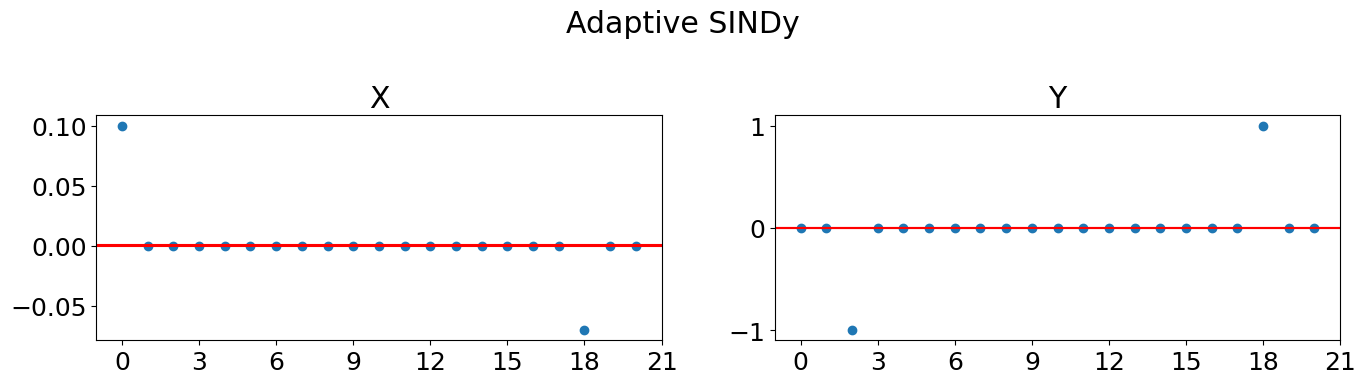

In [10]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

ax[1].plot(COEFF_ADT [:, 1].detach().cpu().numpy(), 'o')
ax[1].set_title('Y')
ax[1].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[1].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[1].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()


In [11]:
print(COEFF_ADT)
print(SINE_ADT )
print(XSINE_ADT)
print(COSINE_ADT)
print(XCOSINE_ADT)
print(EXP_ADT)
print(XEXP_ADT)


tensor([[ 0.1000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -1.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.0700,  1.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[1., 1.],
        [1., 1.]], device='cuda:0', requires_grad=True)
tensor([[0.0108, 0.0132],
        [0.4442, 0.3533]], device='cuda:0', requires

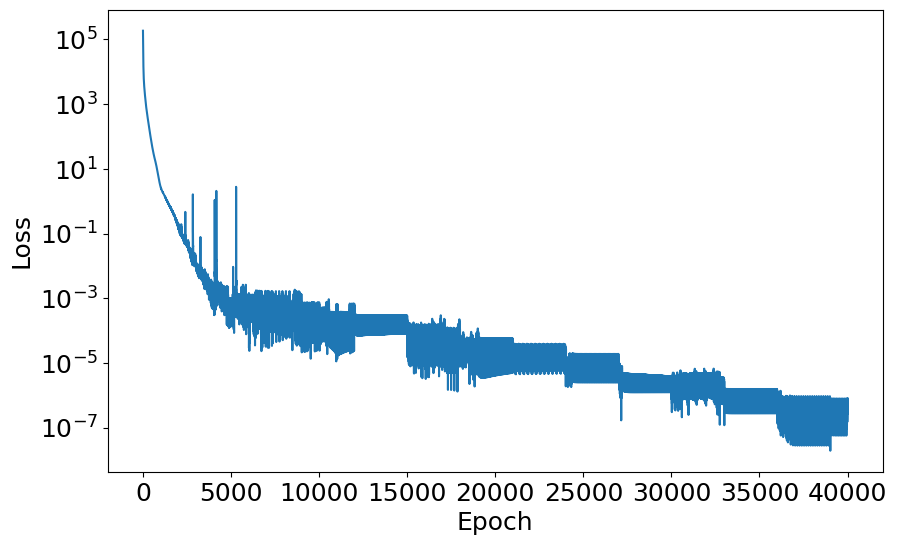

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(False)
plt.savefig('Chemical_Loss_plot.jpeg', dpi = 1200)
plt.show()

In [13]:
# --- Export Loss Data to Tecplot Format ---
loss_np = Loss_data.numpy()
epochs = np.arange(len(loss_np))
loss_data = np.column_stack((epochs, loss_np))

# Header for Tecplot
header = 'VARIABLES = "Epoch", "Loss"\nZONE T="Loss Plot", I={}, F=POINT\n'.format(len(epochs))

# Write to .dat with scientific notation
with open('loss_plot_joint_min.dat', 'w') as f:
    f.write(header)
    np.savetxt(f, loss_data, fmt='%.6e', delimiter='\t')

In [14]:
# Convert tensors to numpy arrays
gamma_correct_np = torch.abs(Gamma_correct).numpy()
gamma_incorrect_np = torch.abs(Gamma_incorrect).numpy()

# Stack data as columns: Epoch, Gamma_correct, Gamma_incorrect
epochs = np.arange(len(gamma_correct_np))
data = np.column_stack((epochs, gamma_correct_np, gamma_incorrect_np))

# Define header for Tecplot
header = 'VARIABLES = "Epoch", "Gamma_Correct", "Gamma_Incorrect"\nZONE T="Gamma Plot", I={}, F=POINT\n'.format(len(epochs))

# Write to .dat file
with open('gamma_plot_joint_min.dat', 'w') as f:
    f.write(header)
    np.savetxt(f, data, fmt='%.4e', delimiter='\t')